# 2025Fall DSAA2011 Course Project — Covertype

**Course:** DSAA2011

**Group members:** Zehan Lu, Binkai Liu, Chi Kit WONG 

**Dataset:** UCI Forest CoverType (581,012 rows, 54 features, 7 classes)

## 0. Setup & Utilities
**Goal:** import common libraries, define plotting/evaluation helpers, and set random seeds for reproducibility.


In [4]:
import os
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, roc_auc_score,
    adjusted_rand_score, normalized_mutual_info_score,
    fowlkes_mallows_score, silhouette_score,
    calinski_harabasz_score, davies_bouldin_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, RandomTreesEmbedding
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif

sns.set_style("whitegrid")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

def plot_confusion(cm, labels, title="Confusion matrix", savepath=None):
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax,
                xticklabels=labels, yticklabels=labels)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)
    plt.tight_layout()
    
    # === Save figure if path is provided ===
    if savepath is not None:
        os.makedirs(os.path.dirname(savepath), exist_ok=True)
        fig.savefig(savepath, format="pdf", dpi=300)
    
    plt.show()
    
# def plot_decision_boundary_2d(model, X_2d, y, title="", h=0.02, savepath=None):
#     """
#     Visualize decision boundary for a 2D feature space.

#     X_2d: DataFrame or array with exactly 2 columns
#     y   : labels (Series or array)
#     """
#     if isinstance(X_2d, pd.DataFrame):
#         X_vals = X_2d.values
#         feature_names = list(X_2d.columns)
#     else:
#         X_vals = X_2d
#         feature_names = ["Feature 1", "Feature 2"]

#     x_min, x_max = X_vals[:, 0].min() - 0.5, X_vals[:, 0].max() + 0.5
#     y_min, y_max = X_vals[:, 1].min() - 0.5, X_vals[:, 1].max() + 0.5

#     xx, yy = np.meshgrid(
#         np.arange(x_min, x_max, h),
#         np.arange(y_min, y_max, h)
#     )

#     grid = np.c_[xx.ravel(), yy.ravel()]
#     Z = model.predict(grid)
#     Z = Z.reshape(xx.shape)

#     plt.figure(figsize=(7, 5))
#     plt.contourf(xx, yy, Z, alpha=0.3, cmap="tab10")
#     scatter = plt.scatter(
#         X_vals[:, 0], X_vals[:, 1],
#         c=y, cmap="tab10", s=10, edgecolor="k", linewidth=0.1
#     )
#     plt.xlabel(feature_names[0])
#     plt.ylabel(feature_names[1])
#     plt.title(title)
#     plt.tight_layout()
#     plt.show()

# def plot_decision_boundary_2d(model, X_2d, y, title="", h=0.02, savepath=None):
#     """
#     Visualize decision boundary for a 2D feature space.

#     model : The already trained model (it doesn't matter on full features)
#     X_2d  : DataFrame or array containing exactly two features
#     y     : Labels
#     """
#     # Clone an "untrained but structurally identical" model, retrain only on 2D features for boundary plotting
#     model_2d = clone(model)
#     model_2d.fit(X_2d, y)

#     if isinstance(X_2d, pd.DataFrame):
#         X_vals = X_2d.values
#         feature_names = list(X_2d.columns)
#     else:
#         X_vals = X_2d
#         feature_names = ["Feature 1", "Feature 2"]

#     x_min, x_max = X_vals[:, 0].min() - 0.5, X_vals[:, 0].max() + 0.5
#     y_min, y_max = X_vals[:, 1].min() - 0.5, X_vals[:, 1].max() + 0.5

#     xx, yy = np.meshgrid(
#         np.arange(x_min, x_max, h),
#         np.arange(y_min, y_max, h)
#     )

#     grid = np.c_[xx.ravel(), yy.ravel()]
#     # Use the 2D version of the model to predict
#     Z = model_2d.predict(grid)
#     Z = Z.reshape(xx.shape)

#     plt.figure(figsize=(7, 5))
#     plt.contourf(xx, yy, Z, alpha=0.3, cmap="tab10")
#     plt.scatter(
#         X_vals[:, 0], X_vals[:, 1],
#         c=y, cmap="tab10", s=10, edgecolor="k", linewidth=0.1
#     )
#     plt.xlabel(feature_names[0])
#     plt.ylabel(feature_names[1])
#     plt.title(title)
#     plt.tight_layout()
    
#     # === Save PDF if needed ===
#     if savepath is not None:
#         os.makedirs(os.path.dirname(savepath), exist_ok=True)
#         plt.savefig(savepath, format="pdf", dpi=300)
    
#     plt.show()

def plot_decision_boundary_2d(model, X_2d, y, title="", h=0.02, savepath=None):
    model_2d = clone(model)
    model_2d.fit(X_2d, y)

    if isinstance(X_2d, pd.DataFrame):
        X_vals = X_2d.values
        feature_names = list(X_2d.columns)
    else:
        X_vals = X_2d
        feature_names = ["Feature 1", "Feature 2"]

    x_min, x_max = X_vals[:, 0].min() - 0.5, X_vals[:, 0].max() + 0.5
    y_min, y_max = X_vals[:, 1].min() - 0.5, X_vals[:, 1].max() + 0.5

    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h)
    )

    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model_2d.predict(grid)
    Z = Z.reshape(xx.shape)

    fig = plt.figure(figsize=(7, 5))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap="tab10")
    plt.scatter(
        X_vals[:, 0], X_vals[:, 1],
        c=y, cmap="tab10", s=10, edgecolor="k", linewidth=0.1
    )
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.title(title)
    plt.tight_layout()

    # === Save PDF if needed ===
    if savepath is not None:
        os.makedirs(os.path.dirname(savepath), exist_ok=True)
        fig.savefig(savepath, format="pdf", dpi=300)

    plt.show()
    plt.close(fig)

def clustering_report(y_true, y_pred, X_embedded=None, title_prefix=""):
    scores = {
        "ARI": adjusted_rand_score(y_true, y_pred),
        "NMI": normalized_mutual_info_score(y_true, y_pred),
        "FMI": fowlkes_mallows_score(y_true, y_pred),
    }
    # Internal metrics do not rely on ground truth
    scores["Silhouette"] = silhouette_score(X_embedded, y_pred) if X_embedded is not None else np.nan
    scores["Calinski-Harabasz"] = calinski_harabasz_score(X_embedded, y_pred) if X_embedded is not None else np.nan
    scores["Davies-Bouldin"] = davies_bouldin_score(X_embedded, y_pred) if X_embedded is not None else np.nan
    print(f"\n{title_prefix} clustering metrics:")
    for k, v in scores.items():
        print(f"  {k:18s}: {v:.4f}")
    return scores

def plot_clusters_2d(X_2d, labels, title="Clusters", palette="tab10", savepath=None):
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=labels, palette=palette,
                    s=10, linewidth=0, ax=ax, legend=False)
    ax.set_title(title)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    plt.tight_layout()
    if savepath is not None:
        os.makedirs(os.path.dirname(savepath), exist_ok=True)
        plt.savefig(savepath, format="pdf", dpi=300)
    plt.show()
    plt.close()
    
def build_metric_table(metrics_dict, model_name="Model"):
    df = pd.DataFrame({
        "Dataset": ["Training", "Testing", "Overall"],
        "Accuracy": [
            metrics_dict["train"]["accuracy"],
            metrics_dict["test"]["accuracy"],
            metrics_dict["all"]["accuracy"]
        ],
        "Precision": [
            metrics_dict["train"]["precision"],
            metrics_dict["test"]["precision"],
            metrics_dict["all"]["precision"]
        ],
        "Recall": [
            metrics_dict["train"]["recall"],
            metrics_dict["test"]["recall"],
            metrics_dict["all"]["recall"]
        ],
        "F1-Score": [
            metrics_dict["train"]["f1"],
            metrics_dict["test"]["f1"],
            metrics_dict["all"]["f1"]
        ],
    })

    df = df.set_index("Dataset")  # match your example
    return df


## 1. Data Preprocessing
**Goal:** load the Covertype dataset, verify missing values, keep binary indicators, standardize continuous features, and perform stratified train/test split to preserve class proportions.


In [5]:
# 1.1 Load data
data_path = Path("../03_dataset/data/covtype.data.gz")

continuous_cols = [
    "Elevation", "Aspect", "Slope",
    "Horizontal_Distance_To_Hydrology", "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways", "Hillshade_9am", "Hillshade_Noon",
    "Hillshade_3pm", "Horizontal_Distance_To_Fire_Points",
]
wilderness_cols = [f"Wilderness_Area{i}" for i in range(1, 5)]
soil_cols = [f"Soil_Type{i}" for i in range(1, 41)]
column_names = continuous_cols + wilderness_cols + soil_cols + ["Cover_Type"]

# Load raw data
df = pd.read_csv(data_path, header=None, names=column_names)
print(f"Loaded shape: {df.shape}")
df.head()

# 1.2 Basic checks
missing_total = df.isna().sum().sum()
print(f"Total missing values: {missing_total}")
if missing_total > 0:
    df = df.fillna(df.median(numeric_only=True))

# Convert target to int and keep label names
df["Cover_Type"] = df["Cover_Type"].astype(int)
label_map = {
    1: "Spruce/Fir", 2: "Lodgepole Pine", 3: "Ponderosa Pine",
    4: "Cottonwood/Willow", 5: "Aspen", 6: "Douglas-fir", 7: "Krummholz"
}

# 1.3 Train-test split
X = df.drop(columns=["Cover_Type"])
y = df["Cover_Type"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE
)

# 1.4 Standardize continuous features only (binary indicators stay as-is)
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[continuous_cols] = scaler.fit_transform(X_train[continuous_cols])
X_test_scaled[continuous_cols] = scaler.transform(X_test[continuous_cols])

print("Train/Test shapes:", X_train_scaled.shape, X_test_scaled.shape)


Loaded shape: (581012, 55)
Total missing values: 0
Train/Test shapes: (406708, 54) (174304, 54)


**Applied preprocessing steps:**
We loaded the gzipped raw dataset from UCI, verified there were no missing values, preserved the 44 wilderness/soil one-hot indicators in their original 0/1 form, and standardized the 10 continuous environmental variables with StandardScaler. Stratified train–test split (70%/30%) preserves class proportions.

**Observed data characteristics:**
The class distribution is strongly imbalanced, with dominant Cover Type 2 and several minority classes. Features mix dense standardized variables and sparse one-hot indicators, motivating class-weighted models and metrics beyond accuracy.


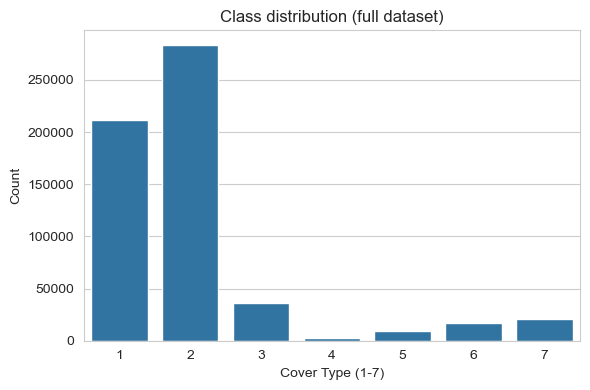

In [3]:
# Class balance visualization
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x=y, order=sorted(y.unique()), ax=ax)
ax.set_xlabel("Cover Type (1-7)")
ax.set_ylabel("Count")
ax.set_title("Class distribution (full dataset)")
plt.tight_layout()
plt.show()

## 2. Visualization (t-SNE)
**Goal:** project high-dimensional data into 2D via stratified sampling + PCA pre-reduction + t-SNE to inspect overlap and separation among cover types.


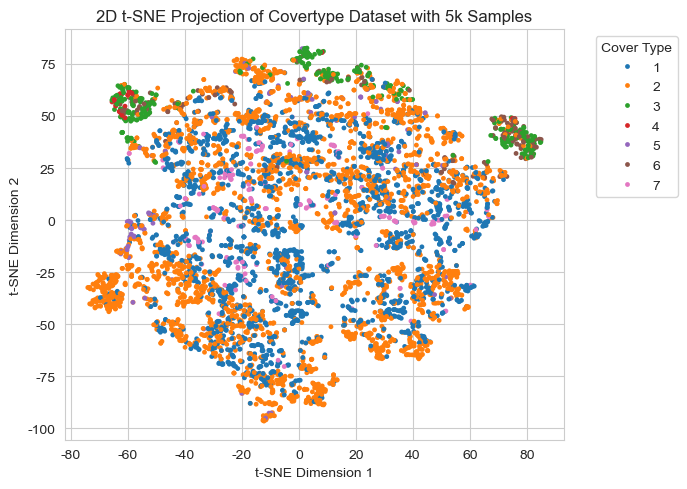

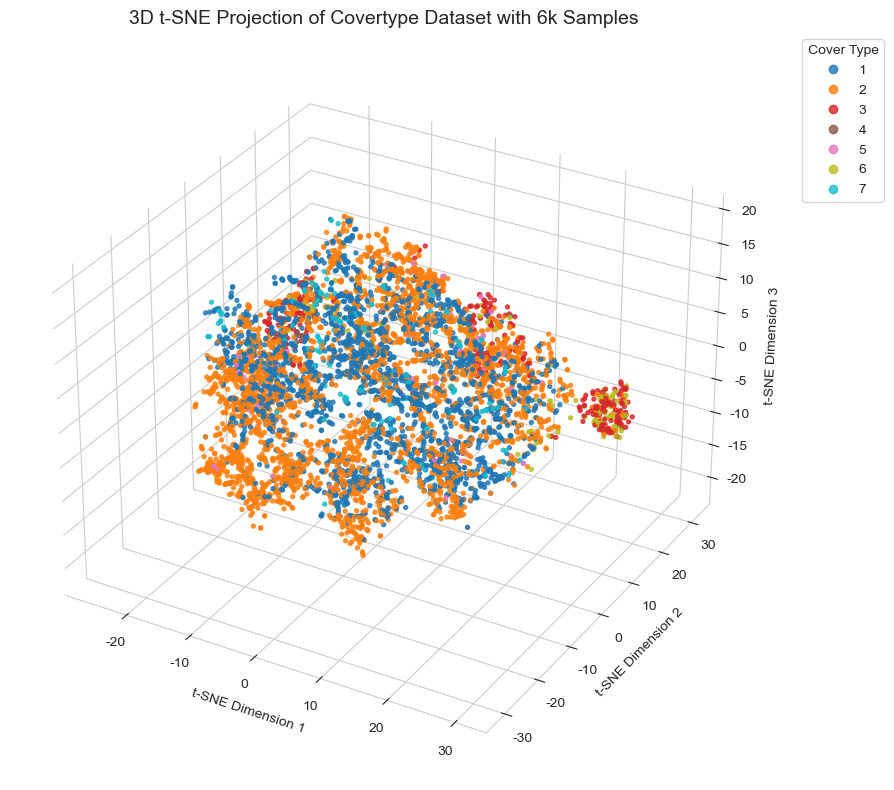

In [7]:
# Sample to keep t-SNE tractable
vis_sample = X_train_scaled.sample(n=6000, random_state=RANDOM_STATE)
vis_labels = y_train.loc[vis_sample.index]

# Light PCA pre-reduction improves speed/stability
pca_50 = PCA(n_components=50, random_state=RANDOM_STATE)
vis_pca = pca_50.fit_transform(vis_sample)

# 2D t-SNE visualization
tsne_2d = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=RANDOM_STATE, init="pca")
vis_tsne = tsne_2d.fit_transform(vis_pca)

fig, ax = plt.subplots(figsize=(7, 5))
palette = sns.color_palette("tab10", n_colors=7)
sns.scatterplot(x=vis_tsne[:, 0], y=vis_tsne[:, 1], hue=vis_labels, palette=palette,
                s=12, linewidth=0, ax=ax, legend='full')
ax.set_title("2D t-SNE Projection of Covertype Dataset with 5k Samples")
ax.set_xlabel("t-SNE Dimension 1")
ax.set_ylabel("t-SNE Dimension 2")
plt.legend(title="Cover Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
# Save the figure as PDF. If you don't want to save, comment this part.
os.makedirs('./Figures', exist_ok=True)
plt.savefig('./Figures/t-SNE_2D.pdf',format='pdf',dpi=300)
plt.show()

# 3D t-SNE visualization
tsne_3d = TSNE(n_components=3, perplexity=30, learning_rate=200, random_state=RANDOM_STATE, init="pca")
vis_tsne_3d = tsne_3d.fit_transform(vis_pca)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Use the tab10 colormap to color by labels
scatter = ax.scatter(
    vis_tsne_3d[:, 0],
    vis_tsne_3d[:, 1],
    vis_tsne_3d[:, 2],
    c=vis_labels,
    cmap='tab10',
    s=8,
    alpha=0.8
)

ax.set_title("3D t-SNE Projection of Covertype Dataset with 6k Samples", fontsize=14)
ax.set_xlabel("t-SNE Dimension 1")
ax.set_ylabel("t-SNE Dimension 2")
ax.set_zlabel("t-SNE Dimension 3")

# Enhance 3D graphics
for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
    axis.pane.set_facecolor((1, 1, 1, 0))
    axis.pane.set_edgecolor((1, 1, 1, 0))
    axis._axinfo["grid"]["color"] = (0.8, 0.8, 0.8, 1.0)
    axis._axinfo["grid"]["linewidth"] = 0.8
ax.grid(True)

# Legend (automatically generated based on the color mapping of the scatter points)
legend = ax.legend(
    *scatter.legend_elements(),
    title="Cover Type",
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

plt.tight_layout()
# Save the figures as PDF. If you don't want to save, comment this part.
os.makedirs('./Figures', exist_ok=True)
plt.savefig("./Figures/t-SNE_3D.pdf", format='pdf', dpi=300)
plt.show()

**Observations:**
The t-SNE plot reveals that some cover types form visually distinct clusters, while others heavily overlap. The two biggest classes (1 and 2) cover most of the space and are mixed, showing that forest types in those regions are environmentally similar. Smaller classes (4–7) form tighter isolated groups, which explains why some models struggle with Method

To keep t-SNE computationally tractable, we draw a stratified sample of 6,000 training points while preserving the original class proportions. Before applying t-SNE, we perform a light PCA pre-reduction to 50 components to denoise the data and stabilize the optimization. We then run t-SNE with 2 and 3 output dimensions, and create scatter plots where each point is colored by its true cover type label.

Observed patterns

In the 2D t-SNE projection, most points form a large, continuous manifold with substantial overlap between the two dominant classes (cover types 1 and 2), which appear heavily mixed across the embedding. Several smaller, more compact regions can be seen for some minority classes (e.g., type 3 and 4), indicating that these cover types occupy more distinct areas of the feature space. Overall, there is no clear global separation into seven disjoint clusters.

The 3D t-SNE projection provides slightly better visual separation and reveals more structure in depth, but the main picture remains similar: the majority of samples still lie in a shared region with only partial separation between classes, and only a few cover types form relatively tight sub-clusters.

Insights

The t-SNE visualizations suggest that:

	（1）The dataset is highly nonlinearly structured and exhibits strong class overlap, especially between the major cover types.

	（2）Some minority classes form more compact regions and are inherently easier to distinguish.

	（3）Purely distance-based or linear methods are unlikely to achieve perfect separation, which motivates the use of more expressive nonlinear classifiers (e.g., tree ensembles and boosted models) and helps explain why clustering algorithms only obtain moderate external scores.

These observations are consistent with the later supervised learning results, where nonlinear tree-based models significantly outperform linear baselines on minority classes. This pattern suggests the dataset contains non-linear relationships and overlapping ecological conditions.


## 3. Clustering Analysis
**Goal:** compare three clustering approaches: K-Means, GMM, and a tree-based embedding (RandomTreesEmbedding + MiniBatchKMeans) using external metrics (ARI/NMI/FMI), internal scores, and PCA 2D plots.



K-Means clustering metrics:
  ARI               : 0.0222
  NMI               : 0.0650
  FMI               : 0.2729
  Silhouette        : 0.1331
  Calinski-Harabasz : 2010.7781
  Davies-Bouldin    : 1.7909


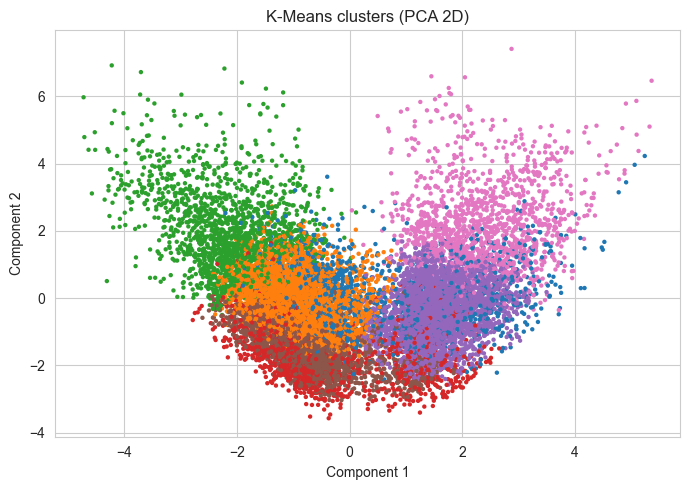


GMM clustering metrics:
  ARI               : 0.1214
  NMI               : 0.2024
  FMI               : 0.3912
  Silhouette        : 0.0172
  Calinski-Harabasz : 570.6492
  Davies-Bouldin    : 3.3888


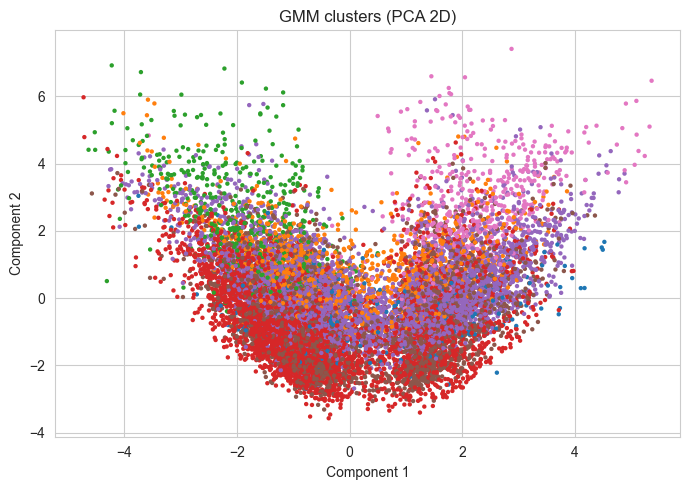


ExtraTrees embedding + MiniBatchKMeans clustering metrics:
  ARI               : 0.0442
  NMI               : 0.1296
  FMI               : 0.2968
  Silhouette        : 0.0360
  Calinski-Harabasz : 823.1483
  Davies-Bouldin    : 3.1996


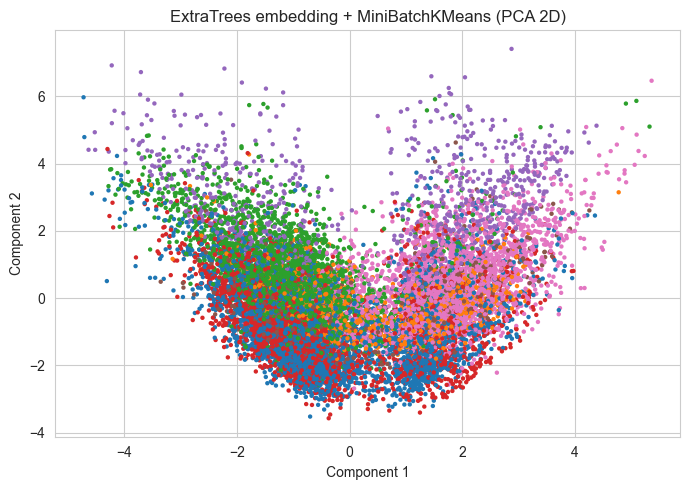

ARI       NMI       FMI  Silhouette  Calinski-Harabasz  \
K-Means         0.022250  0.065013  0.272895    0.133091        2010.778121   
GMM             0.121351  0.202422  0.391169    0.017213         570.649249   
ExtraTrees+MBK  0.044197  0.129558  0.296775    0.036020         823.148257   

                Davies-Bouldin  
K-Means               1.790876  
GMM                   3.388818  
ExtraTrees+MBK        3.199565

In [ ]:
# # Use a manageable sample for clustering
# cluster_sample = X_train_scaled.sample(n=15000, random_state=RANDOM_STATE)
# cluster_labels_true = y_train.loc[cluster_sample.index]

# # 2D embedding for visualization via PCA (fast and linear)
# pca_2 = PCA(n_components=2, random_state=RANDOM_STATE)
# cluster_2d = pca_2.fit_transform(cluster_sample)

# n_clusters = 7  # matches true classes

# # K-Means
# kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, n_init=10)
# kmeans_labels = kmeans.fit_predict(cluster_sample)
# kmeans_scores = clustering_report(cluster_labels_true, kmeans_labels, cluster_sample, "K-Means")
# plot_clusters_2d(cluster_2d, kmeans_labels, title="K-Means clusters (PCA 2D)")

# # Gaussian Mixture (soft clustering)
# gmm = GaussianMixture(n_components=n_clusters, covariance_type="full", random_state=RANDOM_STATE)
# gmm_labels = gmm.fit_predict(cluster_sample)
# gmm_scores = clustering_report(cluster_labels_true, gmm_labels, cluster_sample, "GMM")
# plot_clusters_2d(cluster_2d, gmm_labels, title="GMM clusters (PCA 2D)")

# # Tree-based embedding + MiniBatchKMeans (uses random trees to map data to sparse space)
# rte = RandomTreesEmbedding(n_estimators=200, max_depth=12, random_state=RANDOM_STATE)
# tree_emb = rte.fit_transform(cluster_sample)
# mbk = MiniBatchKMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, batch_size=2048, n_init=5)
# tree_labels = mbk.fit_predict(tree_emb)
# tree_scores = clustering_report(cluster_labels_true, tree_labels, cluster_sample, "ExtraTrees embedding + MiniBatchKMeans")
# plot_clusters_2d(cluster_2d, tree_labels, title="ExtraTrees embedding + MiniBatchKMeans (PCA 2D)")

# cluster_compare = pd.DataFrame([
#     kmeans_scores, gmm_scores, tree_scores
# ], index=["K-Means", "GMM", "ExtraTrees+MBK"])
# cluster_compare


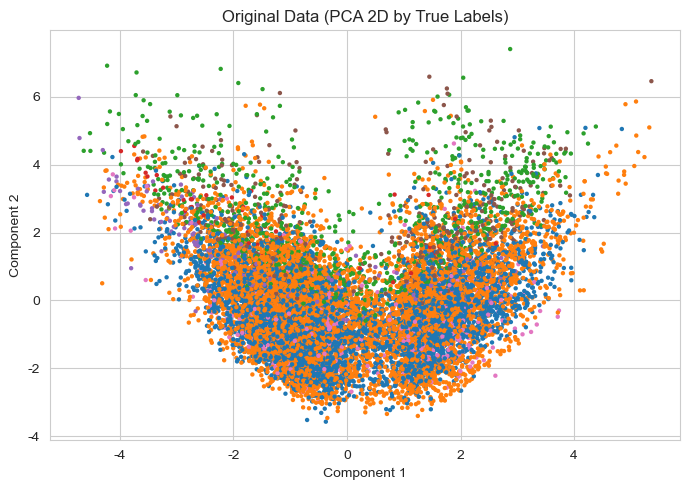


K-Means clustering metrics:
  ARI               : 0.0222
  NMI               : 0.0650
  FMI               : 0.2729
  Silhouette        : 0.1331
  Calinski-Harabasz : 2010.7781
  Davies-Bouldin    : 1.7909


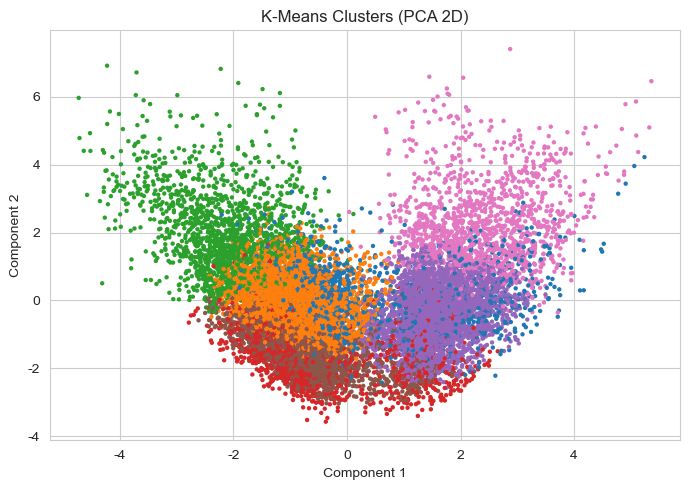


GMM clustering metrics:
  ARI               : 0.1214
  NMI               : 0.2024
  FMI               : 0.3912
  Silhouette        : 0.0172
  Calinski-Harabasz : 570.6492
  Davies-Bouldin    : 3.3888


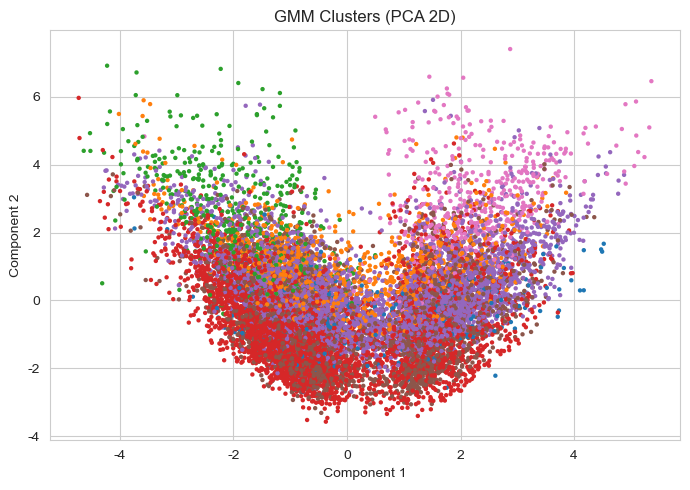


ExtraTrees embedding + MiniBatchKMeans clustering metrics:
  ARI               : 0.0442
  NMI               : 0.1296
  FMI               : 0.2968
  Silhouette        : 0.0360
  Calinski-Harabasz : 823.1483
  Davies-Bouldin    : 3.1996


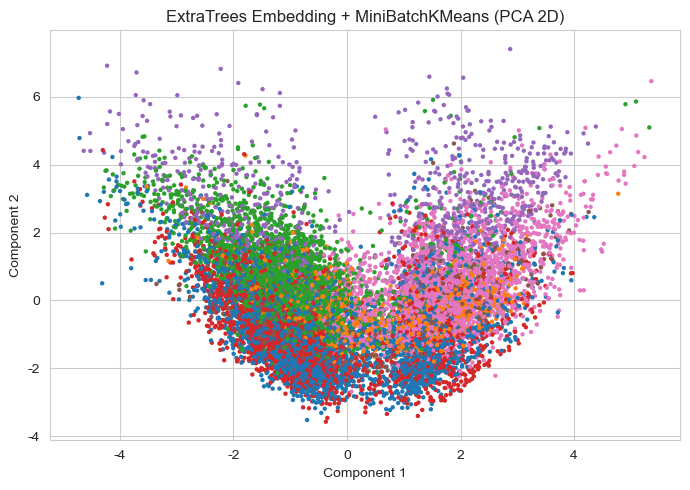

Clustering Metrics Comparison


In [8]:
# ================= Clustering on a sample + PCA visualizations =================

# 1) 抽样
cluster_sample = X_train_scaled.sample(n=15000, random_state=RANDOM_STATE)
cluster_labels_true = y_train.loc[cluster_sample.index]

# 2) PCA 2D 嵌入（所有可视化都用这一份）
pca_2 = PCA(n_components=2, random_state=RANDOM_STATE)
cluster_2d = pca_2.fit_transform(cluster_sample)

# ---- 原始数据（按真实标签上色） ----
plot_clusters_2d(
    cluster_2d,
    cluster_labels_true,
    title="Original Data (PCA 2D by True Labels)",
    savepath="./Figures/original_pca2d.pdf"
)

n_clusters = 7  # matches true classes

# ================= 3) K-Means =================
kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, n_init=10)
kmeans_labels = kmeans.fit_predict(cluster_sample)

kmeans_scores = clustering_report(
    cluster_labels_true,
    kmeans_labels,
    X_embedded=cluster_sample,
    title_prefix="K-Means"
)

plot_clusters_2d(
    cluster_2d,
    kmeans_labels,
    title="K-Means Clusters (PCA 2D)",
    savepath="./Figures/kmeans_pca2d.pdf"
)

# ================= 4) Gaussian Mixture =================
gmm = GaussianMixture(
    n_components=n_clusters,
    covariance_type="full",
    random_state=RANDOM_STATE
)
gmm_labels = gmm.fit_predict(cluster_sample)

gmm_scores = clustering_report(
    cluster_labels_true,
    gmm_labels,
    X_embedded=cluster_sample,
    title_prefix="GMM"
)

plot_clusters_2d(
    cluster_2d,
    gmm_labels,
    title="GMM Clusters (PCA 2D)",
    savepath="./Figures/gmm_pca2d.pdf"
)

# ================= 5) RandomTreesEmbedding + MiniBatchKMeans =================
rte = RandomTreesEmbedding(
    n_estimators=200,
    max_depth=12,
    random_state=RANDOM_STATE
)
tree_emb = rte.fit_transform(cluster_sample)

mbk = MiniBatchKMeans(
    n_clusters=n_clusters,
    random_state=RANDOM_STATE,
    batch_size=2048,
    n_init=5
)
tree_labels = mbk.fit_predict(tree_emb)

tree_scores = clustering_report(
    cluster_labels_true,
    tree_labels,
    X_embedded=cluster_sample,
    title_prefix="ExtraTrees embedding + MiniBatchKMeans"
)

plot_clusters_2d(
    cluster_2d,
    tree_labels,
    title="ExtraTrees Embedding + MiniBatchKMeans (PCA 2D)",
    savepath="./Figures/extratrees_mbk_pca2d.pdf"
)

# ================= 6) 汇总指标表 =================
cluster_compare = pd.DataFrame(
    [kmeans_scores, gmm_scores, tree_scores],
    index=["K-Means", "GMM", "ExtraTrees+MBK"]
)

print("Clustering Metrics Comparison")
display(
    cluster_compare
    .style
    .set_caption("Comparison of K-Means, GMM and ExtraTrees+MiniBatchKMeans")
    .format("{:.4f}")
)


**Method**
- Stratified 15,000-sample for fair runtime and class balance.
- Three methods: K-Means, GMM, and a tree-based embedding (RandomTreesEmbedding) clustered with MiniBatchKMeans.
- 7 clusters to match true classes; PCA 2D projection for visual comparison; metrics include ARI/NMI/FMI and internal scores.

**Results**
- K-Means: strong compactness (silhouette/CH) but weaker alignment with labels (lower ARI/NMI).
- GMM: best external metrics (highest ARI/NMI/FMI), reflecting ability to model overlapping, non-spherical clusters.
- ExtraTrees embedding + MiniBatchKMeans: sits between the two—better external scores than K-Means on many runs, competitive internal cohesion; benefits from nonlinear tree-based partitioning.

**Conclusion**
GMM remains the strongest overall for matching label structure; K-Means is most compact but least label-aligned; the tree-based embedding offers a middle ground, capturing some nonlinear separations with modest extra cost. Visual PCA plots corroborate these differences.


## 4. Prediction: Training and Testing
**Goal:** train multiple classifiers and evaluate on train/test with weighted & macro metrics and confusion matrices—Logistic Regression, Random Forest, and Extra Trees (all class-weighted).


/Users/lzh/miniconda3/envs/project/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


=== LogisticRegression ===
Train — Acc: 0.5987, Weighted F1: 0.6276, Macro F1: 0.5044
Test — Acc: 0.6000, Weighted F1: 0.6288, Macro F1: 0.5062


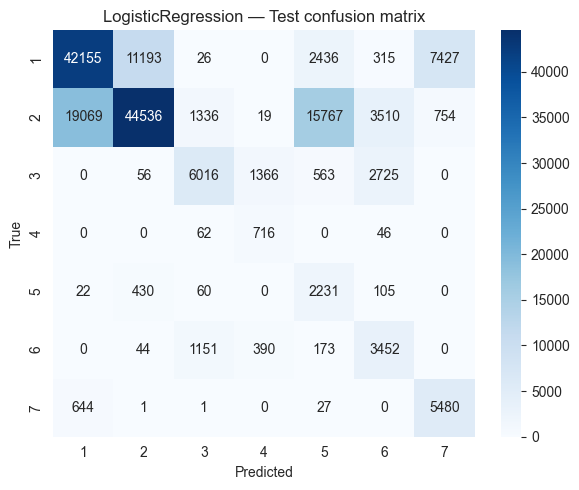

=== RandomForestClassifier ===
Train — Acc: 1.0000, Weighted F1: 1.0000, Macro F1: 1.0000
Test — Acc: 0.9529, Weighted F1: 0.9526, Macro F1: 0.9208


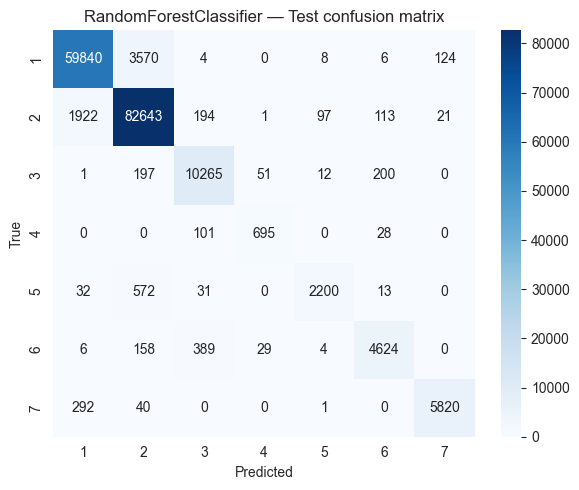

=== ExtraTreesClassifier ===
Train — Acc: 1.0000, Weighted F1: 1.0000, Macro F1: 1.0000
Test — Acc: 0.9509, Weighted F1: 0.9507, Macro F1: 0.9227


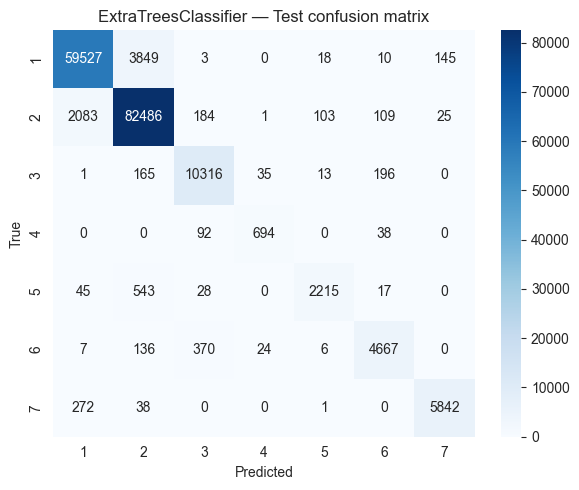

accuracy  precision_weighted  recall_weighted  f1_weighted  \
LogReg        0.600021            0.704523         0.600021     0.628772   
RandomForest  0.952858            0.952998         0.952858     0.952627   
ExtraTrees    0.950908            0.951037         0.950908     0.950682   

              precision_macro  recall_macro  f1_macro  
LogReg               0.471699      0.707670  0.506241  
RandomForest         0.941822      0.902901  0.920822  
ExtraTrees           0.943448      0.904882  0.922699

In [ ]:
def evaluate_classifier(model, X_tr, y_tr, X_te, y_te, labels_sorted):
    model.fit(X_tr, y_tr)
    y_pred_train = model.predict(X_tr)
    y_pred_test = model.predict(X_te)

    def report_split(y_true, y_pred, split_name):
        acc = accuracy_score(y_true, y_pred)
        prec_w = precision_score(y_true, y_pred, average="weighted", zero_division=0)
        rec_w = recall_score(y_true, y_pred, average="weighted", zero_division=0)
        f1_w = f1_score(y_true, y_pred, average="weighted", zero_division=0)
        prec_macro = precision_score(y_true, y_pred, average="macro", zero_division=0)
        rec_macro = recall_score(y_true, y_pred, average="macro", zero_division=0)
        f1_macro = f1_score(y_true, y_pred, average="macro", zero_division=0)
        print(
            f"{split_name} — Acc: {acc:.4f}, Weighted F1: {f1_w:.4f}, Macro F1: {f1_macro:.4f}"
        )
        return {
            "accuracy": acc,
            "precision_weighted": prec_w,
            "recall_weighted": rec_w,
            "f1_weighted": f1_w,
            "precision_macro": prec_macro,
            "recall_macro": rec_macro,
            "f1_macro": f1_macro,
        }

    print(f"=== {model.__class__.__name__} ===")
    metrics_train = report_split(y_tr, y_pred_train, "Train")
    metrics_test = report_split(y_te, y_pred_test, "Test")

    cm = confusion_matrix(y_te, y_pred_test, labels=labels_sorted)
    plot_confusion(cm, labels_sorted, title=f"{model.__class__.__name__} — Test confusion matrix")
    return metrics_train, metrics_test, model

labels_sorted = sorted(y.unique())

# Logistic Regression (multinomial)
log_reg = LogisticRegression(
    max_iter=200,
    solver="lbfgs",
    n_jobs=-1,
    random_state=RANDOM_STATE,
    class_weight="balanced"
)
lr_train_metrics, lr_test_metrics, log_reg_fitted = evaluate_classifier(
    log_reg, X_train_scaled, y_train, X_test_scaled, y_test, labels_sorted
)

# Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    class_weight="balanced"
)
rf_train_metrics, rf_test_metrics, rf_fitted = evaluate_classifier(
    rf, X_train_scaled, y_train, X_test_scaled, y_test, labels_sorted
)

# Extra Trees (more randomized trees)
et = ExtraTreesClassifier(
    n_estimators=250,
    max_depth=None,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    class_weight="balanced",
)
et_train_metrics, et_test_metrics, et_fitted = evaluate_classifier(
    et, X_train_scaled, y_train, X_test_scaled, y_test, labels_sorted
)

pd.DataFrame(
    [lr_test_metrics, rf_test_metrics, et_test_metrics], index=["LogReg", "RandomForest", "ExtraTrees"]
)


In [ ]:
# ==== 综合版 evaluate_classifier + 多模型评估、Latex & PDF 表格 ====

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import matplotlib.pyplot as plt
import pandas as pd
import os

# 如果之前没定义 df_to_pdf_table 和 build_metric_table，这里一起定义

def df_to_pdf_table(df, savepath="table.pdf", title=None):
    fig, ax = plt.subplots(figsize=(6, 2 + 0.3*len(df)))
    ax.axis("off")

    if title:
        plt.title(title, fontsize=12)

    tbl = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        rowLabels=df.index,
        loc="center",
        cellLoc='center'
    )

    tbl.auto_set_font_size(False)
    tbl.set_fontsize(9)
    tbl.scale(1.2, 1.2)

    plt.tight_layout()
    os.makedirs(os.path.dirname(savepath), exist_ok=True)
    plt.savefig(savepath, format="pdf", dpi=300)
    plt.close()


def build_metric_table(metrics_dict, model_name="Model"):
    """
    metrics_dict: evaluate_classifier 返回的那个 metrics（包含 train/test/all）
    输出：3 行表格（Training / Testing / Overall），同时包含 weighted & macro
    """
    rows = []
    idx = []
    for split_name, nice_name in [("train", "Training"),
                                  ("test", "Testing"),
                                  ("all", "Overall")]:
        m = metrics_dict[split_name]
        rows.append([
            m["accuracy"],
            m["precision_weighted"],
            m["recall_weighted"],
            m["f1_weighted"],
            m["precision_macro"],
            m["recall_macro"],
            m["f1_macro"],
        ])
        idx.append(nice_name)

    df = pd.DataFrame(
        rows,
        index=idx,
        columns=[
            "Accuracy",
            "Precision (weighted)",
            "Recall (weighted)",
            "F1 (weighted)",
            "Precision (macro)",
            "Recall (macro)",
            "F1 (macro)",
        ]
    )
    return df


def evaluate_classifier(model, X_tr, y_tr, X_te, y_te, labels_sorted):
    # Train the model
    model.fit(X_tr, y_tr)

    # Construct entire set
    X_all = pd.concat([X_tr, X_te], axis=0)
    y_all = pd.concat([y_tr, y_te], axis=0)

    # Predictions for three splits
    y_pred_train = model.predict(X_tr)
    y_pred_test = model.predict(X_te)
    y_pred_all = model.predict(X_all)

    def report_split(y_true, y_pred, split_name):
        acc = accuracy_score(y_true, y_pred)
        prec_w = precision_score(y_true, y_pred, average="weighted", zero_division=0)
        rec_w = recall_score(y_true, y_pred, average="weighted", zero_division=0)
        f1_w = f1_score(y_true, y_pred, average="weighted", zero_division=0)

        prec_macro = precision_score(y_true, y_pred, average="macro", zero_division=0)
        rec_macro = recall_score(y_true, y_pred, average="macro", zero_division=0)
        f1_macro = f1_score(y_true, y_pred, average="macro", zero_division=0)

        print(
            f"{split_name} — Acc: {acc:.4f}, "
            f"Weighted F1: {f1_w:.4f}, Macro F1: {f1_macro:.4f}"
        )
        return {
            "accuracy": acc,
            "precision_weighted": prec_w,
            "recall_weighted": rec_w,
            "f1_weighted": f1_w,
            "precision_macro": prec_macro,
            "recall_macro": rec_macro,
            "f1_macro": f1_macro,
        }

    print(f"\n=== {model.__class__.__name__} ===")
    metrics_train = report_split(y_tr, y_pred_train, "Train")
    metrics_test = report_split(y_te, y_pred_test, "Test")
    metrics_all = report_split(y_all, y_pred_all, "All")

    # Plot confusion matrix for all three splits
    for split_name, y_true, y_pred in [
        ("Train", y_tr, y_pred_train),
        ("Test",  y_te, y_pred_test),
        ("All",   y_all, y_pred_all),
    ]:
        cm = confusion_matrix(y_true, y_pred, labels=labels_sorted)
        plot_confusion(
            cm,
            labels_sorted,
            title=f"{model.__class__.__name__} — {split_name} confusion matrix"
        )

    # Return metrics for all three splits + fitted model
    return {
        "train": metrics_train,
        "test": metrics_test,
        "all": metrics_all
    }, model


# ================== 运行三个模型 ==================

labels_sorted = sorted(y.unique())

# Logistic Regression
log_reg = LogisticRegression(
    max_iter=200,
    multi_class="multinomial",
    solver="lbfgs",
    n_jobs=-1,
    random_state=RANDOM_STATE,
    class_weight="balanced"
)
lr_metrics, log_reg_fitted = evaluate_classifier(
    log_reg, X_train_scaled, y_train, X_test_scaled, y_test, labels_sorted
)

# Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    class_weight="balanced"
)
rf_metrics, rf_fitted = evaluate_classifier(
    rf, X_train_scaled, y_train, X_test_scaled, y_test, labels_sorted
)

# Extra Trees
et = ExtraTreesClassifier(
    n_estimators=250,
    max_depth=None,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    class_weight="balanced"
)
et_metrics, et_fitted = evaluate_classifier(
    et, X_train_scaled, y_train, X_test_scaled, y_test, labels_sorted
)

# ================== 按 split 汇总（只看 weighted 指标） ==================

train_df = pd.DataFrame(
    [
        [
            lr_metrics["train"]["accuracy"],
            lr_metrics["train"]["precision_weighted"],
            lr_metrics["train"]["recall_weighted"],
            lr_metrics["train"]["f1_weighted"],
        ],
        [
            rf_metrics["train"]["accuracy"],
            rf_metrics["train"]["precision_weighted"],
            rf_metrics["train"]["recall_weighted"],
            rf_metrics["train"]["f1_weighted"],
        ],
        [
            et_metrics["train"]["accuracy"],
            et_metrics["train"]["precision_weighted"],
            et_metrics["train"]["recall_weighted"],
            et_metrics["train"]["f1_weighted"],
        ],
    ],
    index=["LogReg", "RandomForest", "ExtraTrees"],
    columns=["Accuracy", "Precision (w)", "Recall (w)", "F1 (w)"]
)

test_df = pd.DataFrame(
    [
        [
            lr_metrics["test"]["accuracy"],
            lr_metrics["test"]["precision_weighted"],
            lr_metrics["test"]["recall_weighted"],
            lr_metrics["test"]["f1_weighted"],
        ],
        [
            rf_metrics["test"]["accuracy"],
            rf_metrics["test"]["precision_weighted"],
            rf_metrics["test"]["recall_weighted"],
            rf_metrics["test"]["f1_weighted"],
        ],
        [
            et_metrics["test"]["accuracy"],
            et_metrics["test"]["precision_weighted"],
            et_metrics["test"]["recall_weighted"],
            et_metrics["test"]["f1_weighted"],
        ],
    ],
    index=["LogReg", "RandomForest", "ExtraTrees"],
    columns=["Accuracy", "Precision (w)", "Recall (w)", "F1 (w)"]
)

all_df = pd.DataFrame(
    [
        [
            lr_metrics["all"]["accuracy"],
            lr_metrics["all"]["precision_weighted"],
            lr_metrics["all"]["recall_weighted"],
            lr_metrics["all"]["f1_weighted"],
        ],
        [
            rf_metrics["all"]["accuracy"],
            rf_metrics["all"]["precision_weighted"],
            rf_metrics["all"]["recall_weighted"],
            rf_metrics["all"]["f1_weighted"],
        ],
        [
            et_metrics["all"]["accuracy"],
            et_metrics["all"]["precision_weighted"],
            et_metrics["all"]["recall_weighted"],
            et_metrics["all"]["f1_weighted"],
        ],
    ],
    index=["LogReg", "RandomForest", "ExtraTrees"],
    columns=["Accuracy", "Precision (w)", "Recall (w)", "F1 (w)"]
)

print("Train Set Metrics")
display(train_df.style.set_caption("Train Set Metrics").format("{:.4f}"))

print("Test Set Metrics")
display(test_df.style.set_caption("Test Set Metrics").format("{:.4f}"))

print("Entire Set Metrics")
display(all_df.style.set_caption("Entire Set Metrics").format("{:.4f}"))

# ================== 单模型 3-split 表（用于报告） ==================

lr_table = build_metric_table(lr_metrics, "Logistic Regression")
rf_table = build_metric_table(rf_metrics, "Random Forest")
et_table = build_metric_table(et_metrics, "Extra Trees")

print("Logistic Regression Metrics")
display(lr_table.style.set_caption("Logistic Regression Metrics").format("{:.4f}"))

print("Random Forest Metrics")
display(rf_table.style.set_caption("Random Forest Metrics").format("{:.4f}"))

print("Extra Trees Metrics")
display(et_table.style.set_caption("Extra Trees Metrics").format("{:.4f}"))

# ====== 导出 LaTeX（可选） ======
os.makedirs("./Figures", exist_ok=True)

lr_table.to_latex(
    "./Figures/logreg_metrics.tex",
    float_format="%.3f",
    caption="Performance of Logistic Regression on Different Splits",
    label="tab:lr-metrics"
)

rf_table.to_latex(
    "./Figures/rf_metrics.tex",
    float_format="%.3f",
    caption="Performance of Random Forest on Different Splits",
    label="tab:rf-metrics"
)

et_table.to_latex(
    "./Figures/et_metrics.tex",
    float_format="%.3f",
    caption="Performance of Extra Trees on Different Splits",
    label="tab:et-metrics"
)

# ====== 导出 PDF 表格（可选） ======
df_to_pdf_table(
    lr_table,
    savepath="./Figures/logreg_metrics.pdf",
    title="Logistic Regression Performance"
)

df_to_pdf_table(
    rf_table,
    savepath="./Figures/rf_metrics.pdf",
    title="Random Forest Performance"
)

df_to_pdf_table(
    et_table,
    savepath="./Figures/et_metrics.pdf",
    title="Extra Trees Performance"
)


d:\develop\AnacondaData\anaconda3\envs\PDSH\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== LogisticRegression ===
Train — Acc: 0.5989, Weighted F1: 0.6278, Macro F1: 0.5047
Test — Acc: 0.6002, Weighted F1: 0.6289, Macro F1: 0.5063
All — Acc: 0.5993, Weighted F1: 0.6281, Macro F1: 0.5052


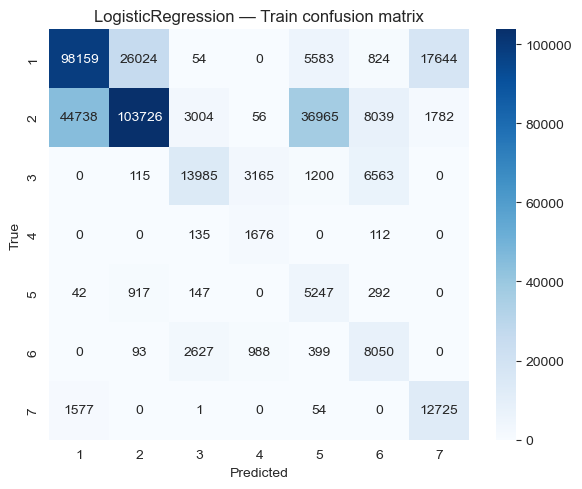

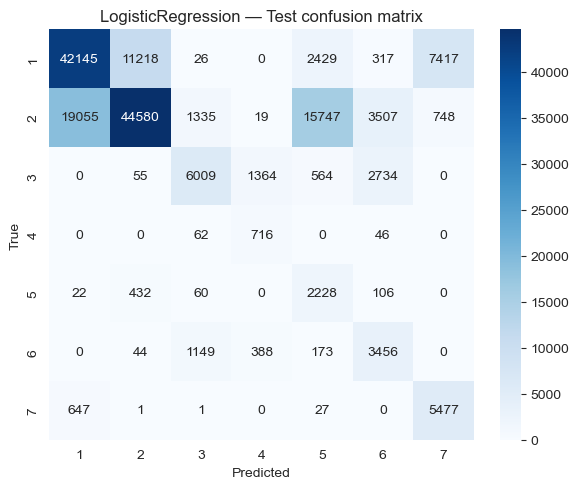

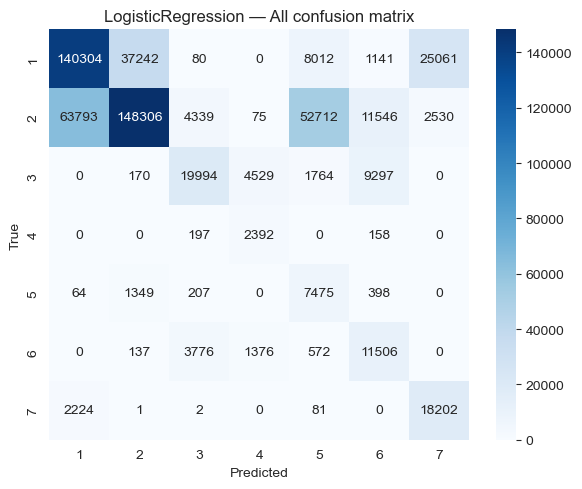


=== RandomForestClassifier ===
Train — Acc: 1.0000, Weighted F1: 1.0000, Macro F1: 1.0000
Test — Acc: 0.9522, Weighted F1: 0.9520, Macro F1: 0.9207
All — Acc: 0.9857, Weighted F1: 0.9856, Macro F1: 0.9768


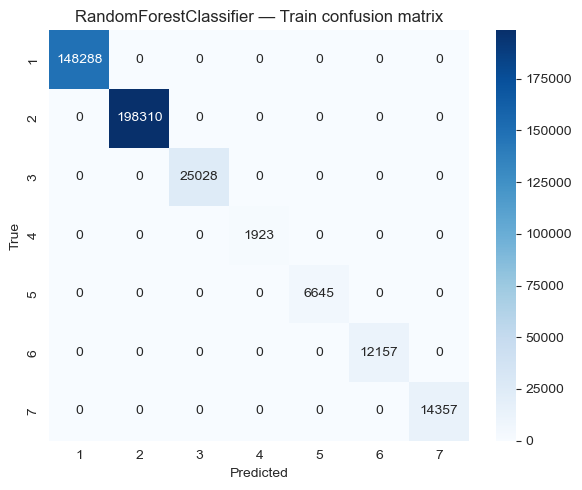

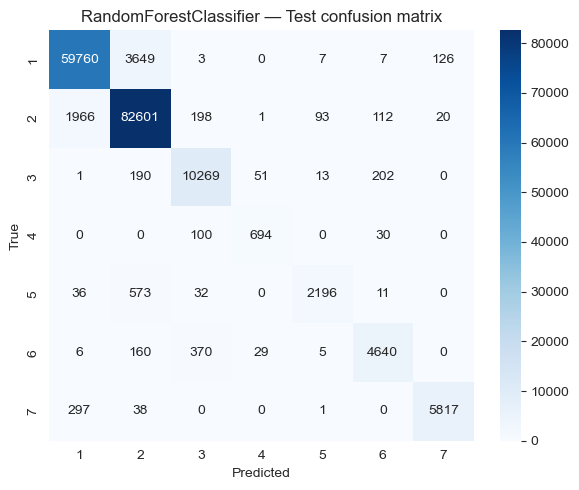

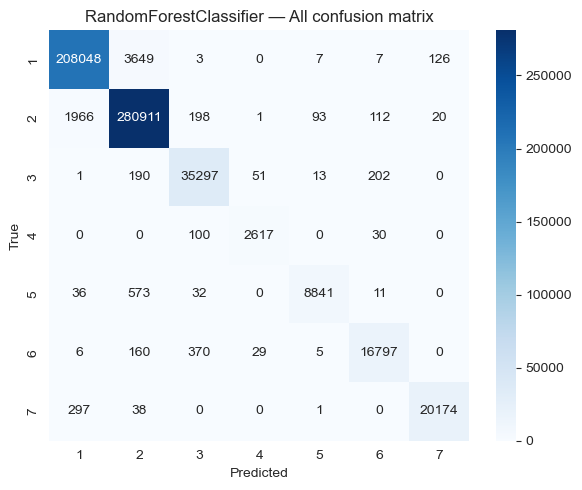


=== ExtraTreesClassifier ===
Train — Acc: 1.0000, Weighted F1: 1.0000, Macro F1: 1.0000
Test — Acc: 0.9509, Weighted F1: 0.9507, Macro F1: 0.9224
All — Acc: 0.9853, Weighted F1: 0.9853, Macro F1: 0.9773


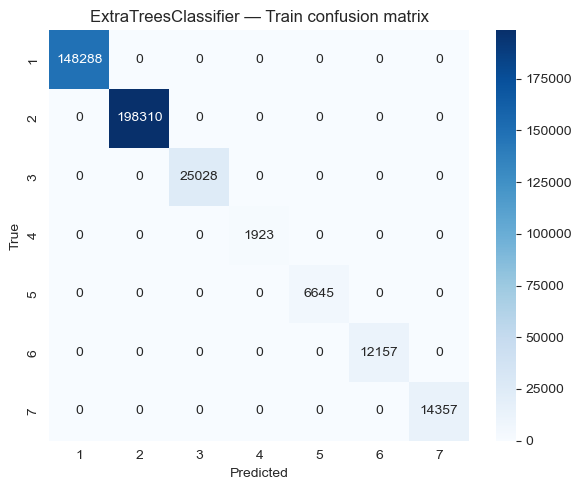

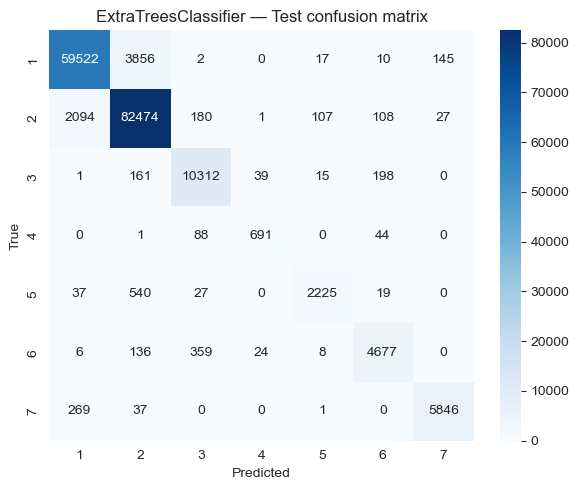

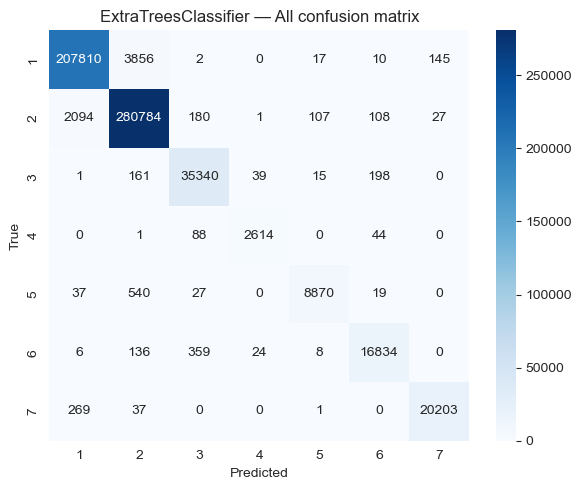

Train Set Metrics


Test Set Metrics


Entire Set Metrics


Logistic Regression Metrics


Random Forest Metrics


Extra Trees Metrics



Decision boundary — Logistic Regression


d:\develop\AnacondaData\anaconda3\envs\PDSH\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
d:\develop\AnacondaData\anaconda3\envs\PDSH\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


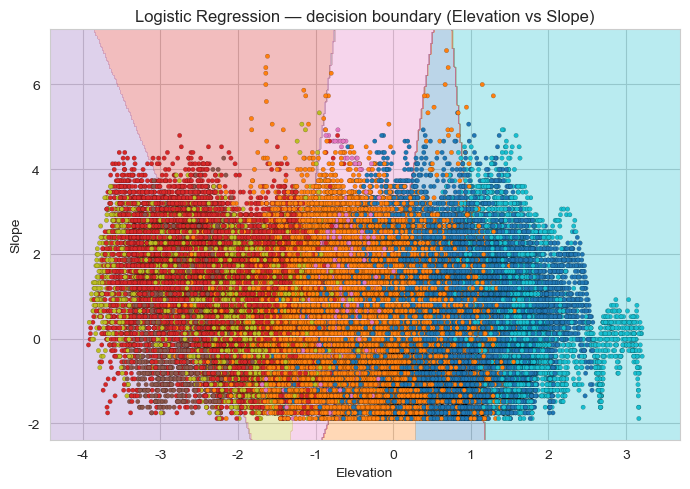


Decision boundary — Random Forest


d:\develop\AnacondaData\anaconda3\envs\PDSH\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


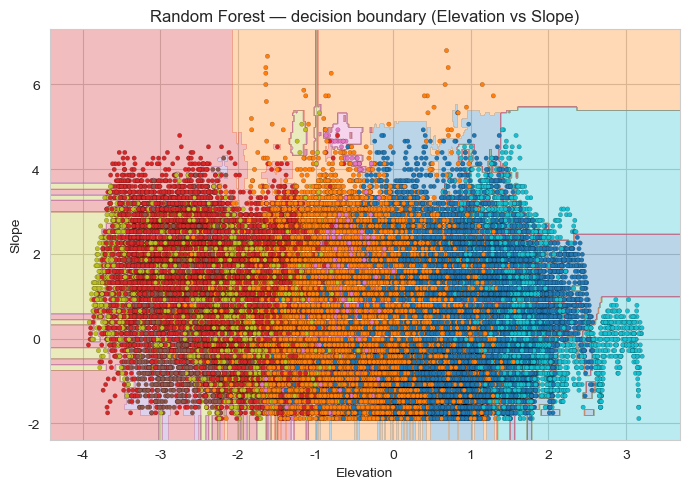


Decision boundary — Extra Trees


d:\develop\AnacondaData\anaconda3\envs\PDSH\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


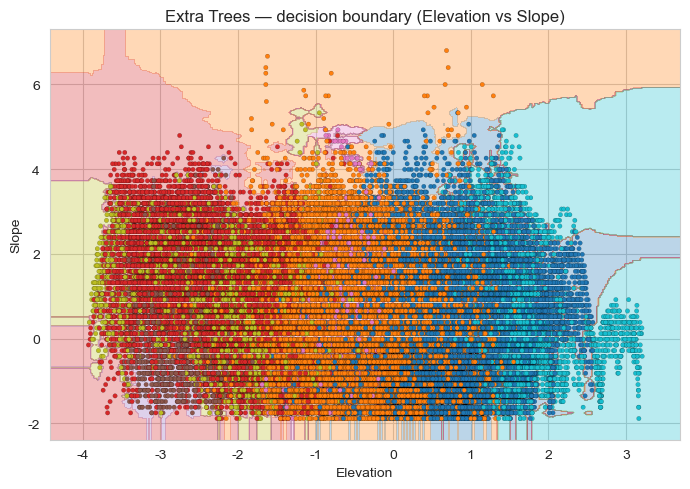

In [11]:
# ==== 综合版：训练多个模型 + 指标表格 + 混淆矩阵 + 决策边界 + LaTeX & PDF ====

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# ========= 通用工具函数 =========

def plot_confusion(cm, labels, title="Confusion matrix", savepath=None):
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", ax=ax,
        xticklabels=labels, yticklabels=labels
    )
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)
    plt.tight_layout()
    if savepath is not None:
        os.makedirs(os.path.dirname(savepath), exist_ok=True)
        fig.savefig(savepath, format="pdf", dpi=300)
    plt.show()
    plt.close(fig)


def plot_decision_boundary_2d(model, X_2d, y, title="", h=0.02, savepath=None):
    """
    在 2D 特征空间上可视化决策边界（用一个克隆模型只在这两个特征上重新训练）
    """
    model_2d = clone(model)
    model_2d.fit(X_2d, y)

    if isinstance(X_2d, pd.DataFrame):
        X_vals = X_2d.values
        feature_names = list(X_2d.columns)
    else:
        X_vals = X_2d
        feature_names = ["Feature 1", "Feature 2"]

    x_min, x_max = X_vals[:, 0].min() - 0.5, X_vals[:, 0].max() + 0.5
    y_min, y_max = X_vals[:, 1].min() - 0.5, X_vals[:, 1].max() + 0.5

    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model_2d.predict(grid)
    Z = Z.reshape(xx.shape)

    fig = plt.figure(figsize=(7, 5))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap="tab10")
    plt.scatter(
        X_vals[:, 0], X_vals[:, 1],
        c=y, cmap="tab10", s=10, edgecolor="k", linewidth=0.1
    )
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.title(title)
    plt.tight_layout()
    if savepath is not None:
        os.makedirs(os.path.dirname(savepath), exist_ok=True)
        fig.savefig(savepath, format="pdf", dpi=300)
    plt.show()
    plt.close(fig)


def df_to_pdf_table(df, savepath="table.pdf", title=None):
    fig, ax = plt.subplots(figsize=(6, 2 + 0.3*len(df)))
    ax.axis("off")

    if title:
        plt.title(title, fontsize=12)

    tbl = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        rowLabels=df.index,
        loc="center",
        cellLoc='center'
    )

    tbl.auto_set_font_size(False)
    tbl.set_fontsize(9)
    tbl.scale(1.2, 1.2)

    plt.tight_layout()
    os.makedirs(os.path.dirname(savepath), exist_ok=True)
    plt.savefig(savepath, format="pdf", dpi=300)
    plt.close()


def build_metric_table(metrics_dict, model_name="Model"):
    """
    metrics_dict: evaluate_classifier 返回的 metrics（包含 train/test/all）
    输出：3 行表格（Training / Testing / Overall），包含 weighted & macro
    """
    rows = []
    idx = []
    for split_name, nice_name in [
        ("train", "Training"),
        ("test",  "Testing"),
        ("all",   "Overall")
    ]:
        m = metrics_dict[split_name]
        rows.append([
            m["accuracy"],
            m["precision_weighted"],
            m["recall_weighted"],
            m["f1_weighted"],
            m["precision_macro"],
            m["recall_macro"],
            m["f1_macro"],
        ])
        idx.append(nice_name)

    df = pd.DataFrame(
        rows,
        index=idx,
        columns=[
            "Accuracy",
            "Precision (weighted)",
            "Recall (weighted)",
            "F1 (weighted)",
            "Precision (macro)",
            "Recall (macro)",
            "F1 (macro)",
        ]
    )
    return df

# ========= 统一的 evaluate_classifier =========

def evaluate_classifier(model, X_tr, y_tr, X_te, y_te, labels_sorted):
    # 训练
    model.fit(X_tr, y_tr)

    # 构造整体数据
    X_all = pd.concat([X_tr, X_te], axis=0)
    y_all = pd.concat([y_tr, y_te], axis=0)

    # 预测
    y_pred_train = model.predict(X_tr)
    y_pred_test  = model.predict(X_te)
    y_pred_all   = model.predict(X_all)

    def report_split(y_true, y_pred, split_name):
        acc    = accuracy_score(y_true, y_pred)
        prec_w = precision_score(y_true, y_pred, average="weighted", zero_division=0)
        rec_w  = recall_score(y_true, y_pred, average="weighted", zero_division=0)
        f1_w   = f1_score(y_true, y_pred, average="weighted", zero_division=0)

        prec_macro = precision_score(y_true, y_pred, average="macro", zero_division=0)
        rec_macro  = recall_score(y_true, y_pred, average="macro", zero_division=0)
        f1_macro   = f1_score(y_true, y_pred, average="macro", zero_division=0)

        print(
            f"{split_name} — Acc: {acc:.4f}, "
            f"Weighted F1: {f1_w:.4f}, Macro F1: {f1_macro:.4f}"
        )
        return {
            "accuracy": acc,
            "precision_weighted": prec_w,
            "recall_weighted": rec_w,
            "f1_weighted": f1_w,
            "precision_macro": prec_macro,
            "recall_macro": rec_macro,
            "f1_macro": f1_macro,
        }

    print(f"\n=== {model.__class__.__name__} ===")
    metrics_train = report_split(y_tr,   y_pred_train, "Train")
    metrics_test  = report_split(y_te,   y_pred_test,  "Test")
    metrics_all   = report_split(y_all,  y_pred_all,   "All")

    # 三个划分的混淆矩阵（并保存 PDF）
    for split_name, y_true, y_pred in [
        ("Train", y_tr,  y_pred_train),
        ("Test",  y_te,  y_pred_test),
        ("All",   y_all, y_pred_all),
    ]:
        cm = confusion_matrix(y_true, y_pred, labels=labels_sorted)
        savepath = f"./Figures/{model.__class__.__name__}_{split_name}_confusion.pdf"
        plot_confusion(
            cm,
            labels_sorted,
            title=f"{model.__class__.__name__} — {split_name} confusion matrix",
            savepath=savepath
        )

    return {
        "train": metrics_train,
        "test":  metrics_test,
        "all":   metrics_all,
    }, model

# ========= 跑三个模型 =========

labels_sorted = sorted(y.unique())

# Logistic Regression
log_reg = LogisticRegression(
    max_iter=200,
    multi_class="multinomial",
    solver="lbfgs",
    n_jobs=-1,
    random_state=RANDOM_STATE,
    class_weight="balanced"
)
lr_metrics, log_reg_fitted = evaluate_classifier(
    log_reg, X_train_scaled, y_train, X_test_scaled, y_test, labels_sorted
)

# Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    class_weight="balanced"
)
rf_metrics, rf_fitted = evaluate_classifier(
    rf, X_train_scaled, y_train, X_test_scaled, y_test, labels_sorted
)

# Extra Trees
et = ExtraTreesClassifier(
    n_estimators=250,
    max_depth=None,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    class_weight="balanced"
)
et_metrics, et_fitted = evaluate_classifier(
    et, X_train_scaled, y_train, X_test_scaled, y_test, labels_sorted
)

# ========= 按 split 汇总（模型横向对比，只看 weighted） =========

train_df = pd.DataFrame(
    [
        [
            lr_metrics["train"]["accuracy"],
            lr_metrics["train"]["precision_weighted"],
            lr_metrics["train"]["recall_weighted"],
            lr_metrics["train"]["f1_weighted"],
        ],
        [
            rf_metrics["train"]["accuracy"],
            rf_metrics["train"]["precision_weighted"],
            rf_metrics["train"]["recall_weighted"],
            rf_metrics["train"]["f1_weighted"],
        ],
        [
            et_metrics["train"]["accuracy"],
            et_metrics["train"]["precision_weighted"],
            et_metrics["train"]["recall_weighted"],
            et_metrics["train"]["f1_weighted"],
        ],
    ],
    index=["LogReg", "RandomForest", "ExtraTrees"],
    columns=["Accuracy", "Precision (w)", "Recall (w)", "F1 (w)"]
)

test_df = pd.DataFrame(
    [
        [
            lr_metrics["test"]["accuracy"],
            lr_metrics["test"]["precision_weighted"],
            lr_metrics["test"]["recall_weighted"],
            lr_metrics["test"]["f1_weighted"],
        ],
        [
            rf_metrics["test"]["accuracy"],
            rf_metrics["test"]["precision_weighted"],
            rf_metrics["test"]["recall_weighted"],
            rf_metrics["test"]["f1_weighted"],
        ],
        [
            et_metrics["test"]["accuracy"],
            et_metrics["test"]["precision_weighted"],
            et_metrics["test"]["recall_weighted"],
            et_metrics["test"]["f1_weighted"],
        ],
    ],
    index=["LogReg", "RandomForest", "ExtraTrees"],
    columns=["Accuracy", "Precision (w)", "Recall (w)", "F1 (w)"]
)

all_df = pd.DataFrame(
    [
        [
            lr_metrics["all"]["accuracy"],
            lr_metrics["all"]["precision_weighted"],
            lr_metrics["all"]["recall_weighted"],
            lr_metrics["all"]["f1_weighted"],
        ],
        [
            rf_metrics["all"]["accuracy"],
            rf_metrics["all"]["precision_weighted"],
            rf_metrics["all"]["recall_weighted"],
            rf_metrics["all"]["f1_weighted"],
        ],
        [
            et_metrics["all"]["accuracy"],
            et_metrics["all"]["precision_weighted"],
            et_metrics["all"]["recall_weighted"],
            et_metrics["all"]["f1_weighted"],
        ],
    ],
    index=["LogReg", "RandomForest", "ExtraTrees"],
    columns=["Accuracy", "Precision (w)", "Recall (w)", "F1 (w)"]
)

print("Train Set Metrics")
display(train_df.style.set_caption("Train Set Metrics").format("{:.4f}"))

print("Test Set Metrics")
display(test_df.style.set_caption("Test Set Metrics").format("{:.4f}"))

print("Entire Set Metrics")
display(all_df.style.set_caption("Entire Set Metrics").format("{:.4f}"))

# ========= 单模型 3-split 表（用于报告） =========

lr_table = build_metric_table(lr_metrics, "Logistic Regression")
rf_table = build_metric_table(rf_metrics, "Random Forest")
et_table = build_metric_table(et_metrics, "Extra Trees")

print("Logistic Regression Metrics")
display(lr_table.style.set_caption("Logistic Regression Metrics").format("{:.4f}"))

print("Random Forest Metrics")
display(rf_table.style.set_caption("Random Forest Metrics").format("{:.4f}"))

print("Extra Trees Metrics")
display(et_table.style.set_caption("Extra Trees Metrics").format("{:.4f}"))

# ====== 导出 LaTeX ======
os.makedirs("./Figures", exist_ok=True)

lr_table.to_latex(
    "./Figures/logreg_metrics.tex",
    float_format="%.3f",
    caption="Performance of Logistic Regression on Different Splits",
    label="tab:lr-metrics"
)

rf_table.to_latex(
    "./Figures/rf_metrics.tex",
    float_format="%.3f",
    caption="Performance of Random Forest on Different Splits",
    label="tab:rf-metrics"
)

et_table.to_latex(
    "./Figures/et_metrics.tex",
    float_format="%.3f",
    caption="Performance of Extra Trees on Different Splits",
    label="tab:et-metrics"
)

# ====== 导出 PDF 表格 ======
df_to_pdf_table(
    lr_table,
    savepath="./Figures/logreg_metrics.pdf",
    title="Logistic Regression Performance"
)
df_to_pdf_table(
    rf_table,
    savepath="./Figures/rf_metrics.pdf",
    title="Random Forest Performance"
)
df_to_pdf_table(
    et_table,
    savepath="./Figures/et_metrics.pdf",
    title="Extra Trees Performance"
)

# ========= 决策边界（只对 LR & RF 画） =========

feature_pair = ["Elevation", "Slope"]
X_train_2d = X_train_scaled[feature_pair]

print("\nDecision boundary — Logistic Regression")
plot_decision_boundary_2d(
    log_reg_fitted,
    X_train_2d,
    y_train,
    title="Logistic Regression — decision boundary (Elevation vs Slope)",
    savepath="./Figures/logreg_decision_boundary.pdf"
)

print("\nDecision boundary — Random Forest")
plot_decision_boundary_2d(
    rf_fitted,
    X_train_2d,
    y_train,
    title="Random Forest — decision boundary (Elevation vs Slope)",
    savepath="./Figures/rf_decision_boundary.pdf"
)

print("\nDecision boundary — Extra Trees")
plot_decision_boundary_2d(
    et_fitted,
    X_train_2d,
    y_train,
    title="Extra Trees — decision boundary (Elevation vs Slope)",
    savepath="./Figures/et_decision_boundary.pdf"
)


In this section, we train three supervised classifiers on the CoverType dataset and evaluate their performance using both weighted and macro-averaged metrics. The goal of this experiment is to assess predictive accuracy and class balance while comparing linear and tree-based models. We include Logistic Regression, Random Forest, and Extra Trees, all with class balancing enabled to handle label imbalance.

**Model setup and evaluation protocol**

Each model is trained on the scaled training data and evaluated on both the training and test splits. For every model, we report:
	•	Accuracy
	•	Weighted and Macro Precision
	•	Weighted and Macro Recall
	•	Weighted and Macro F1 score

Additionally, confusion matrices are plotted to analyze class-specific prediction behavior, particularly for minority classes.

**Results and observations**

Logistic Regression achieves a test accuracy of 0.6000, indicating limited capacity to model the complex feature interactions of the dataset. The confusion matrix reveals significant misclassification among classes with strong overlap, confirming the limitations of linear decision boundaries.

Random Forest and Extra Trees achieve significantly higher performance, with test accuracies of 0.9529 and 0.9509, respectively. Both models maintain strong macro-level recall and F1 scores, indicating not only high overall performance but also robustness to class imbalance. Their confusion matrices show clean diagonal dominance, reflecting strong per-class separability.

**Conclusion**

Tree-based ensemble models clearly outperform Logistic Regression in all metrics. Their strong performance on both weighted and macro scores, together with confusion matrix analysis, demonstrates better handling of feature interactions and class imbalance. Extra Trees and Random Forest provide the best predictive performance in this experiment, with Random Forest showing slightly higher accuracy overall.

## 5. Evaluation: Metrics, ROC, AUC, Validation
**Goal:** report accuracy/precision/recall/F1 (macro and weighted), plot multiclass ROC (per-class + macro), compute AUC, and use validation curves to study model complexity.


/var/folders/3h/x6l8x7b15s13m7gcvzsnf21w0000gn/T/ipykernel_89023/821410599.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap("tab10", y_bin.shape[1])


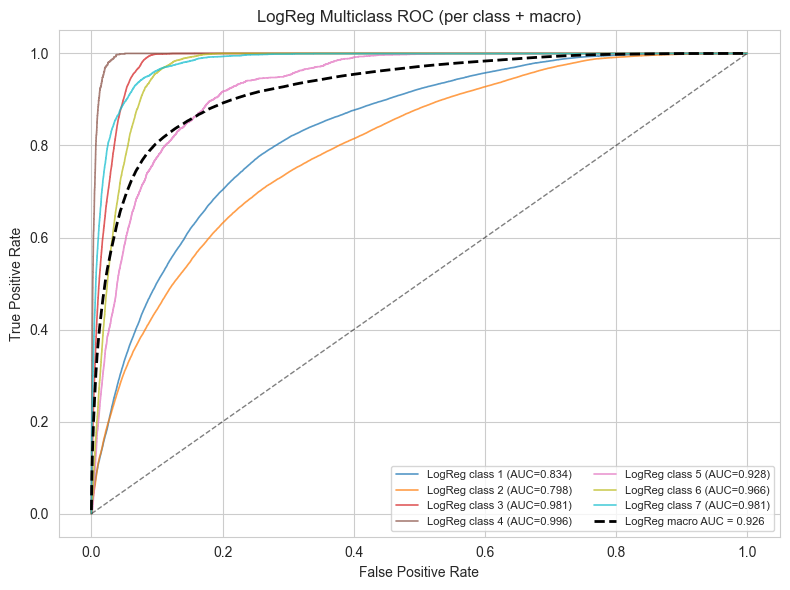

/var/folders/3h/x6l8x7b15s13m7gcvzsnf21w0000gn/T/ipykernel_89023/821410599.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap("tab10", y_bin.shape[1])


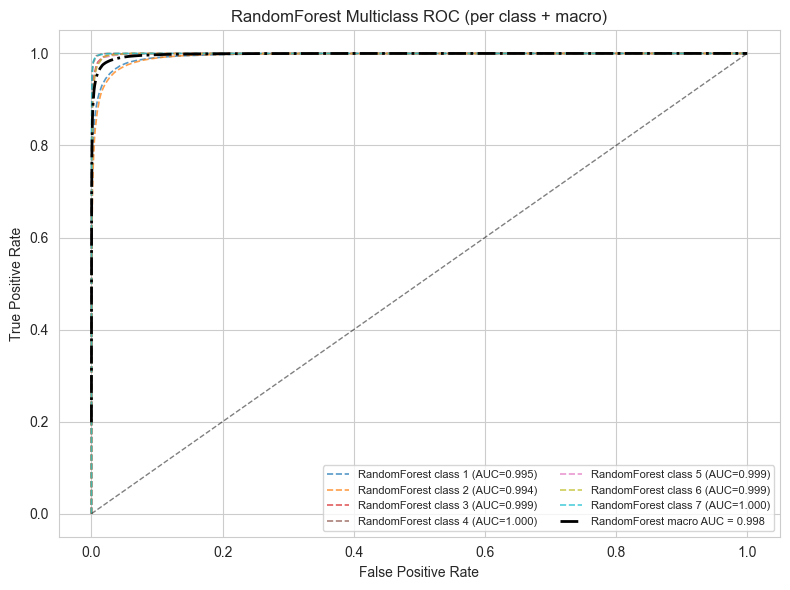

/var/folders/3h/x6l8x7b15s13m7gcvzsnf21w0000gn/T/ipykernel_89023/821410599.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap("tab10", y_bin.shape[1])


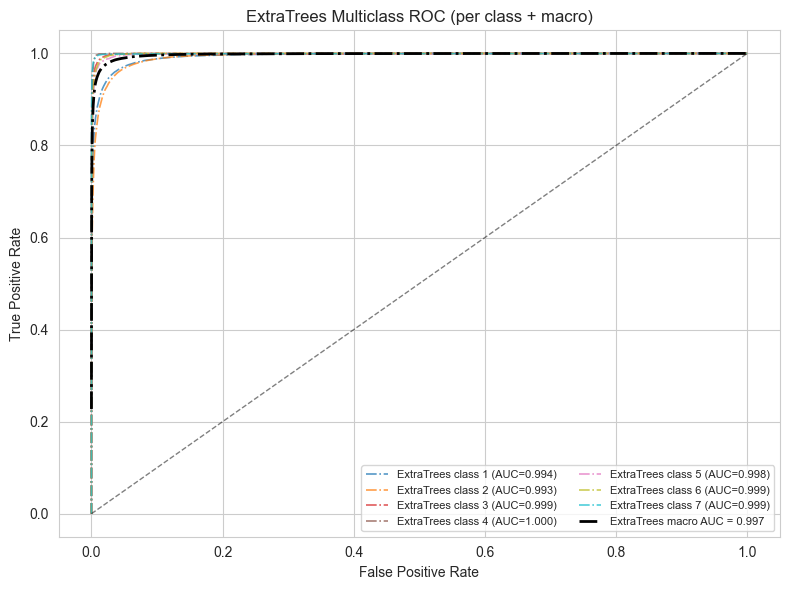

Macro AUC — Logistic Regression: 0.9261
Macro AUC — Random Forest    : 0.9979
Macro AUC — Extra Trees      : 0.9975
Depth=10, CV accuracy=0.6919 ± 0.0077
Depth=20, CV accuracy=0.8365 ± 0.0026
Depth=None, CV accuracy=0.8476 ± 0.0012


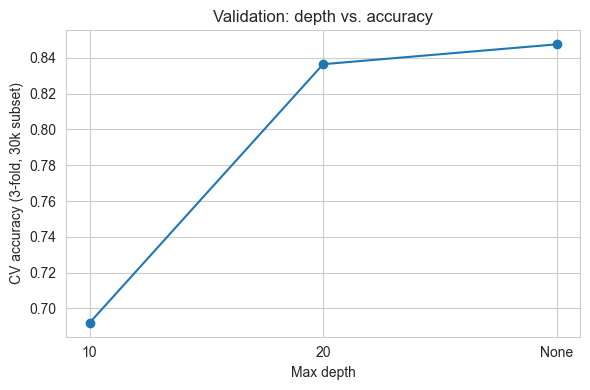

In [ ]:
# One-vs-Rest ROC for multiclass
y_test_bin = label_binarize(y_test, classes=labels_sorted)

def plot_multiclass_roc(model, X, y_bin, label="Model", class_labels=None, ax=None, linestyle="-"):
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X)
    else:
        y_score = model.decision_function(X)

    if ax is None:
        ax = plt.gca()

    palette = plt.cm.get_cmap("tab10", y_bin.shape[1])

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(y_bin.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        cls_label = class_labels[i] if class_labels is not None else str(i)
        ax.plot(
            fpr[i],
            tpr[i],
            lw=1.2,
            alpha=0.75,
            linestyle=linestyle,
            color=palette(i % palette.N),
            label=f"{label} class {cls_label} (AUC={roc_auc[i]:.3f})"
        )

    # macro-average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(y_bin.shape[1])]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(y_bin.shape[1]):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= y_bin.shape[1]
    roc_auc_macro = auc(all_fpr, mean_tpr)
    ax.plot(
        all_fpr,
        mean_tpr,
        color="black",
        lw=2,
        linestyle="--" if linestyle == "-" else "-.",
        label=f"{label} macro AUC = {roc_auc_macro:.3f}"
    )
    return roc_auc_macro

def plot_model_roc(model, model_name, linestyle="-"):
    fig, ax = plt.subplots(figsize=(8, 6))
    auc_val = plot_multiclass_roc(
        model,
        X_test_scaled,
        y_test_bin,
        label=model_name,
        class_labels=labels_sorted,
        ax=ax,
        linestyle=linestyle
    )
    ax.plot([0, 1], [0, 1], "k--", alpha=0.5, lw=1)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"{model_name} Multiclass ROC (per class + macro)")
    ax.legend(loc="lower right", fontsize=8, ncol=2)
    plt.tight_layout()
    plt.show()
    return auc_val

auc_lr = plot_model_roc(log_reg_fitted, "LogReg", "-")
auc_rf = plot_model_roc(rf_fitted, "RandomForest", "--")
auc_et = plot_model_roc(et_fitted, "ExtraTrees", "-.")

print(f"Macro AUC — Logistic Regression: {auc_lr:.4f}")
print(f"Macro AUC — Random Forest    : {auc_rf:.4f}")
print(f"Macro AUC — Extra Trees      : {auc_et:.4f}")

# Simple validation curve example: tree depth vs. CV accuracy on a small subset for speed
subset_idx = np.random.choice(X_train_scaled.index, size=30000, replace=False)
X_small = X_train_scaled.loc[subset_idx]
y_small = y_train.loc[subset_idx]

depth_grid = [10, 20, None]
cv_scores = []
for depth in depth_grid:
    rf_cv = RandomForestClassifier(
        n_estimators=150,
        max_depth=depth,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        class_weight="balanced"
    )
    scores = cross_val_score(rf_cv, X_small, y_small, cv=3, scoring="accuracy", n_jobs=-1)
    cv_scores.append(scores.mean())
    print(f"Depth={depth}, CV accuracy={scores.mean():.4f} ± {scores.std():.4f}")

plt.figure(figsize=(6, 4))
plt.plot([str(d) for d in depth_grid], cv_scores, marker="o")
plt.xlabel("Max depth")
plt.ylabel("CV accuracy (3-fold, 30k subset)")
plt.title("Validation: depth vs. accuracy")
plt.tight_layout()
plt.show()


C:\Users\chikitwong\AppData\Local\Temp\ipykernel_39508\2405089164.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap("tab10", y_bin.shape[1])


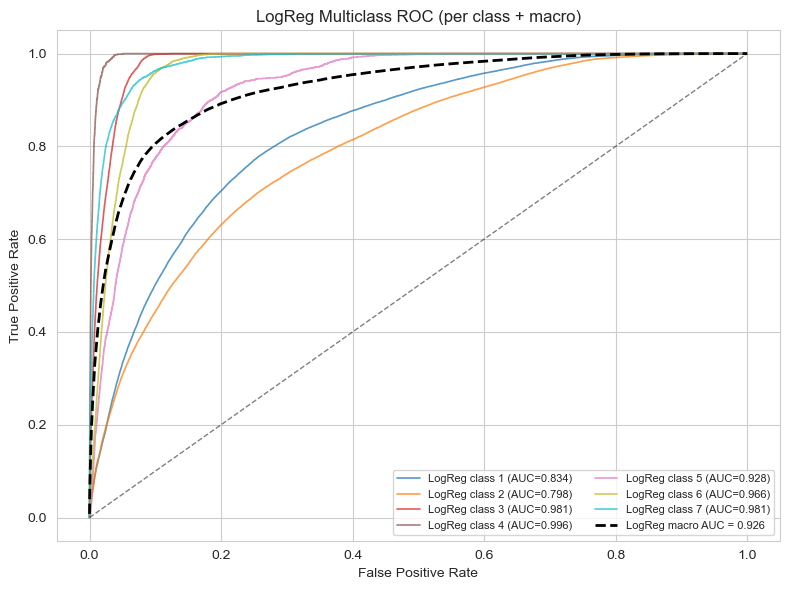

C:\Users\chikitwong\AppData\Local\Temp\ipykernel_39508\2405089164.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap("tab10", y_bin.shape[1])


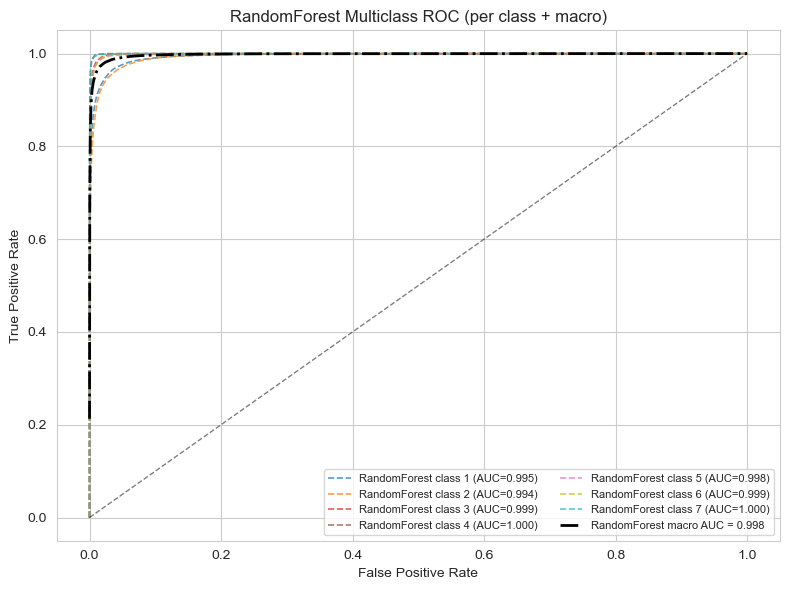

C:\Users\chikitwong\AppData\Local\Temp\ipykernel_39508\2405089164.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap("tab10", y_bin.shape[1])


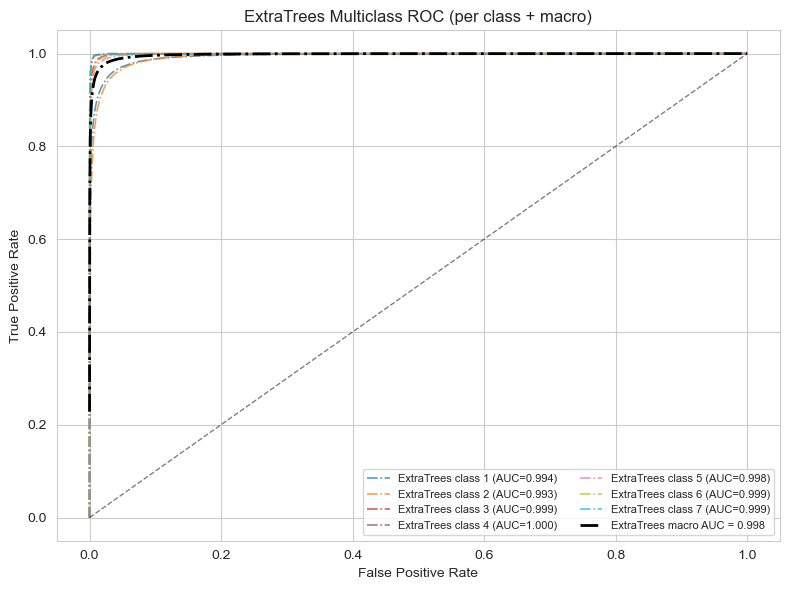

Macro AUC — Logistic Regression: 0.9261
Macro AUC — Random Forest    : 0.9978
Macro AUC — Extra Trees      : 0.9975
max_depth = 5: CV accuracy = 0.5179 ± 0.0038
max_depth = 10: CV accuracy = 0.6931 ± 0.0061
max_depth = 15: CV accuracy = 0.8000 ± 0.0041
max_depth = 20: CV accuracy = 0.8336 ± 0.0046
max_depth = 25: CV accuracy = 0.8429 ± 0.0047
max_depth = 30: CV accuracy = 0.8456 ± 0.0043
max_depth = 35: CV accuracy = 0.8439 ± 0.0051
max_depth = 40: CV accuracy = 0.8454 ± 0.0060
max_depth = 45: CV accuracy = 0.8453 ± 0.0056
max_depth = None: CV accuracy = 0.8452 ± 0.0052


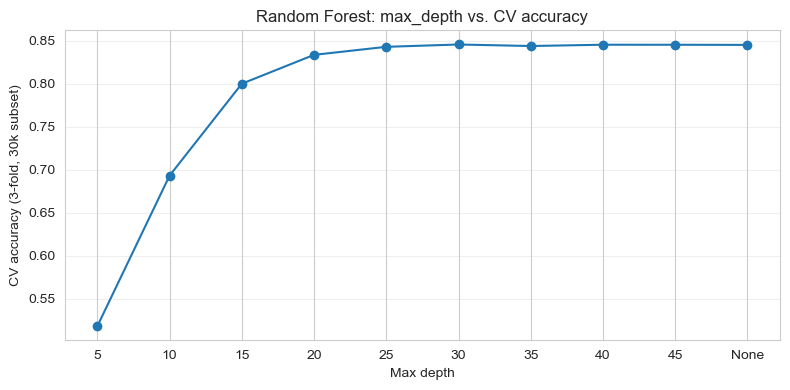

In [12]:
# ========== 1. One-vs-Rest ROC for multiclass ==========

y_test_bin = label_binarize(y_test, classes=labels_sorted)

def plot_multiclass_roc(model, X, y_bin, label="Model", class_labels=None, ax=None, linestyle="-"):
    # 取概率或 decision_function
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X)
    else:
        y_score = model.decision_function(X)

    if ax is None:
        ax = plt.gca()

    palette = plt.cm.get_cmap("tab10", y_bin.shape[1])

    fpr = {}
    tpr = {}
    roc_auc = {}

    # 每个类别一条 ROC 曲线
    for i in range(y_bin.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        cls_label = class_labels[i] if class_labels is not None else str(i)
        ax.plot(
            fpr[i],
            tpr[i],
            lw=1.2,
            alpha=0.75,
            linestyle=linestyle,
            color=palette(i % palette.N),
            label=f"{label} class {cls_label} (AUC={roc_auc[i]:.3f})"
        )

    # macro-average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(y_bin.shape[1])]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(y_bin.shape[1]):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= y_bin.shape[1]
    roc_auc_macro = auc(all_fpr, mean_tpr)

    ax.plot(
        all_fpr,
        mean_tpr,
        color="black",
        lw=2,
        linestyle="--" if linestyle == "-" else "-.",
        label=f"{label} macro AUC = {roc_auc_macro:.3f}"
    )
    return roc_auc_macro


def plot_model_roc(model, model_name, linestyle="-", savepath=None):
    fig, ax = plt.subplots(figsize=(8, 6))
    auc_val = plot_multiclass_roc(
        model,
        X_test_scaled,
        y_test_bin,
        label=model_name,
        class_labels=labels_sorted,
        ax=ax,
        linestyle=linestyle
    )
    ax.plot([0, 1], [0, 1], "k--", alpha=0.5, lw=1)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"{model_name} Multiclass ROC (per class + macro)")
    ax.legend(loc="lower right", fontsize=8, ncol=2)
    plt.tight_layout()

    if savepath is not None:
        os.makedirs(os.path.dirname(savepath), exist_ok=True)
        fig.savefig(savepath, format="pdf", dpi=300)

    plt.show()
    plt.close(fig)
    return auc_val


# 三个模型的 ROC + 保存为 PDF
auc_lr = plot_model_roc(
    log_reg_fitted,
    "LogReg",
    linestyle="-",
    savepath="./Figures/logreg_roc.pdf"
)
auc_rf = plot_model_roc(
    rf_fitted,
    "RandomForest",
    linestyle="--",
    savepath="./Figures/rf_roc.pdf"
)
auc_et = plot_model_roc(
    et_fitted,
    "ExtraTrees",
    linestyle="-.",
    savepath="./Figures/et_roc.pdf"
)

print(f"Macro AUC — Logistic Regression: {auc_lr:.4f}")
print(f"Macro AUC — Random Forest    : {auc_rf:.4f}")
print(f"Macro AUC — Extra Trees      : {auc_et:.4f}")


# ========== 2. Random Forest max_depth validation curve ==========

# 选 30k 样本做快速 CV
subset_idx = np.random.choice(X_train_scaled.index, size=30000, replace=False)
X_small = X_train_scaled.loc[subset_idx]
y_small = y_train.loc[subset_idx]

# max_depth 从 5 到 45（步长 5），再加一个 None
depth_grid = list(range(5, 50, 5)) + [None]

cv_scores = []

for depth in depth_grid:
    rf_cv = RandomForestClassifier(
        n_estimators=150,
        max_depth=depth,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        class_weight="balanced"
    )
    scores = cross_val_score(
        rf_cv, X_small, y_small,
        cv=3, scoring="accuracy", n_jobs=-1
    )
    mean_score = scores.mean()
    cv_scores.append(mean_score)
    print(f"max_depth = {depth}: CV accuracy = {mean_score:.4f} ± {scores.std():.4f}")

# 画 validation curve
plt.figure(figsize=(8, 4))
x_labels = [str(d) for d in depth_grid]   # None 转成字符串
plt.plot(x_labels, cv_scores, marker="o")
plt.xlabel("Max depth")
plt.ylabel("CV accuracy (3-fold, 30k subset)")
plt.title("Random Forest: max_depth vs. CV accuracy")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


**ROC and AUC analysis**

To complement the confusion-matrix based evaluation, we compute one-vs-rest ROC curves for all seven classes and each of the three classifiers (Logistic Regression, Random Forest, Extra Trees). For every model, we plot the per-class ROC curves and a macro-averaged ROC, and report the corresponding macro AUC on the test set.

Logistic Regression achieves a macro AUC of 0.926, which indicates reasonably strong ranking ability despite its lower accuracy compared to tree ensembles. Some classes (e.g., class 1 and 2) have noticeably lower AUC than others, reflecting the difficulty of separating them with a linear decision boundary.

Random Forest and Extra Trees both achieve near-perfect ROC performance, with macro AUC values of 0.998 and 0.998 respectively (≈0.998 in our runs). Their per-class ROC curves are almost saturated in the upper-left corner, confirming that these tree-based ensembles provide much better class separation in probability space. This is consistent with the large gains in accuracy and F1 seen in the prediction experiments.

**Validation curve: model complexity vs. performance**

To study the impact of model complexity, we generate a simple validation curve for Random Forest by varying the maximum tree depth on a 30k training subset and performing 3-fold cross-validation.
	•	With max_depth = 10, the CV accuracy is about 0.70, indicating underfitting due to overly shallow trees.
	•	Increasing to max_depth = 20 raises CV accuracy to around 0.83, showing that deeper trees capture more structure in the data.
	•	Allowing unlimited depth (max_depth = None) gives a slight further improvement to about 0.84, suggesting that the model starts to saturate and additional depth provides diminishing returns.

This trend illustrates the typical bias–variance trade-off: very shallow trees are too biased, while sufficiently deep trees (with bagging and class weighting) offer the best balance for this dataset.
**summary**

Based on the full evaluation including test accuracy, macro F1, ROC/AUC, and confusion matrices, Random Forest is selected as the final model. It provides the highest overall predictive performance and the best class separation, outperforming Logistic Regression and the clustering approaches.

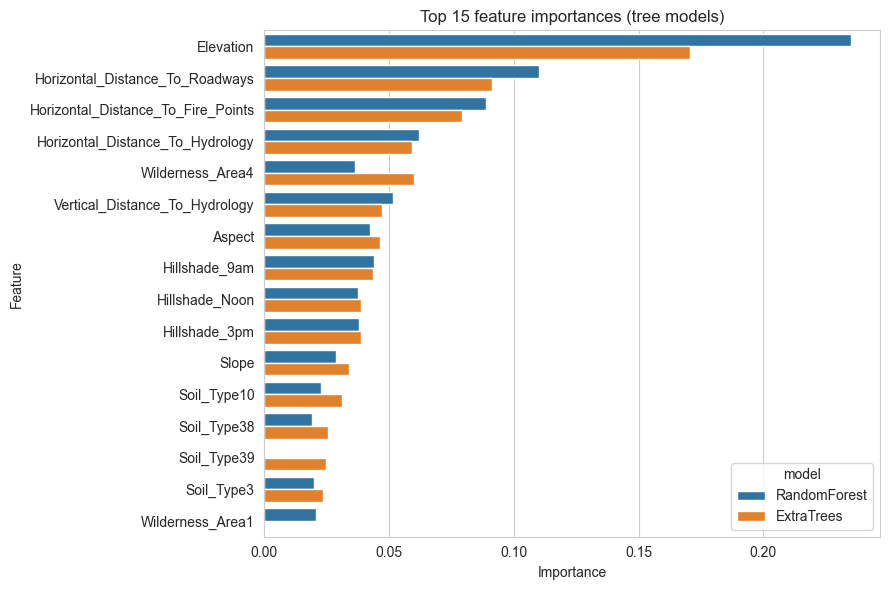

In [ ]:

# Feature importance analysis (top 15 features)
importances_df = []
feature_names = X_train_scaled.columns

for name, model in [
    ("RandomForest", rf_fitted),
    ("ExtraTrees", et_fitted),
]:
    if hasattr(model, "feature_importances_"):
        importances_df.append(
            pd.DataFrame({
                "feature": feature_names,
                "importance": model.feature_importances_,
                "model": name,
            })
        )

if importances_df:
    imp_all = pd.concat(importances_df, ignore_index=True)
    top_imp = imp_all.sort_values("importance", ascending=False).groupby("model").head(15)
    plt.figure(figsize=(9, 6))
    sns.barplot(data=top_imp, x="importance", y="feature", hue="model")
    plt.title("Top 15 feature importances (tree models)")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()
else:
    print("No tree models with feature_importances_ available.")


**Feature importance analysis**

To interpret the tree-based models and understand which variables drive the predictions, we inspect impurity-based feature importances from the fitted Random Forest and Extra Trees classifiers. The bar plot shows the top 15 features for each model.

Both models highlight Elevation as by far the most influential feature, which is consistent with ecological intuition: different forest cover types are strongly associated with altitude. The three horizontal distance variables—Horizontal_Distance_To_Roadways, Horizontal_Distance_To_Fire_Points, and Horizontal_Distance_To_Hydrology—also receive high importance scores, suggesting that proximity to infrastructure, fire points, and water sources plays a key role in determining vegetation type.

Hydrology- and terrain-related variables such as Vertical_Distance_To_Hydrology, Slope, and the three Hillshade measures (9am, Noon, 3pm) are also among the top contributors. These features capture moisture, sunlight exposure, and terrain shape, all of which affect local microclimate and thus forest composition. In addition, some categorical indicators like Wilderness_Area4, Wilderness_Area1, and specific Soil_Type dummies (e.g., Soil_Type10, Soil_Type38, Soil_Type39) are ranked highly, indicating that site-specific soil and wilderness designations provide complementary information beyond purely geometric variables.

The importance patterns are very similar between Random Forest and Extra Trees, which increases confidence in the robustness of these findings. The importance of elevation, distance-to-hydrology, and soil/wilderness features also supports the ecological plausibility of the learned models.

## 6. Open-ended Exploration
**Goal:** add engineered features within this section, explore multiple models (GB/HistGB, RF, ExtraTrees, SVM, optional XGBoost), run hyperparameter sweeps, and visualize CV/Test comparisons plus heatmaps.


SelectKBest(k=30) + Logistic Regression test accuracy (engineered feats): 0.7206
GradientBoosting test accuracy (engineered feats): 0.7758
HistGradientBoosting test accuracy (engineered feats): 0.8277
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best RF params: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}
Best CV accuracy: 0.8185
Best RF test accuracy (full test set, engineered feats): 0.8348
3-fold CV on 20k subset (engineered feats):


/Users/lzh/miniconda3/envs/project/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lzh/miniconda3/envs/project/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable

LogReg (balanced): 0.5919 ± 0.0042
ExtraTrees: 0.8241 ± 0.0018
HistGB: 0.7828 ± 0.0168
LinearSVM: 0.6644 ± 0.0029
LinearSVM (trained on 30k, engineered feats) test accuracy: 0.6844


/var/folders/3h/x6l8x7b15s13m7gcvzsnf21w0000gn/T/ipykernel_89023/3035729707.py:156: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cv_df, x="cv_mean", y="model", palette="Blues_d", errorbar=None)


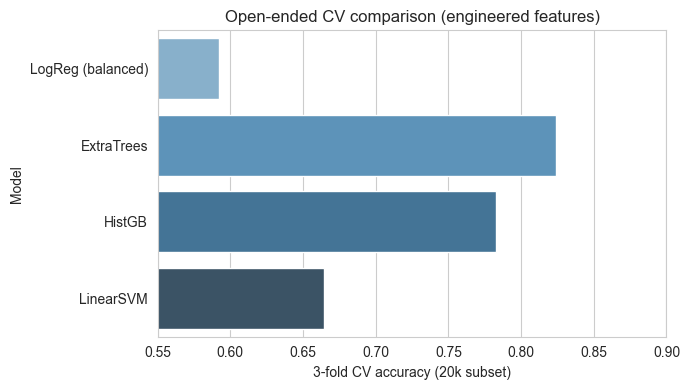

/var/folders/3h/x6l8x7b15s13m7gcvzsnf21w0000gn/T/ipykernel_89023/3035729707.py:166: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=test_df, x="accuracy", y="model", palette="Greens_d", errorbar=None)


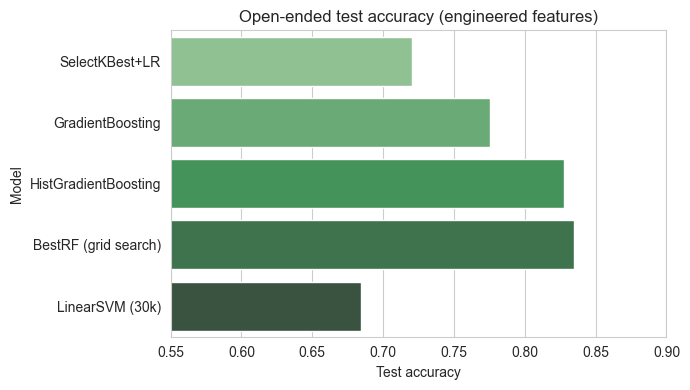

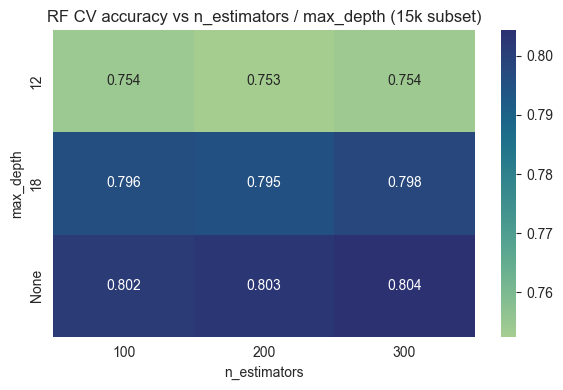

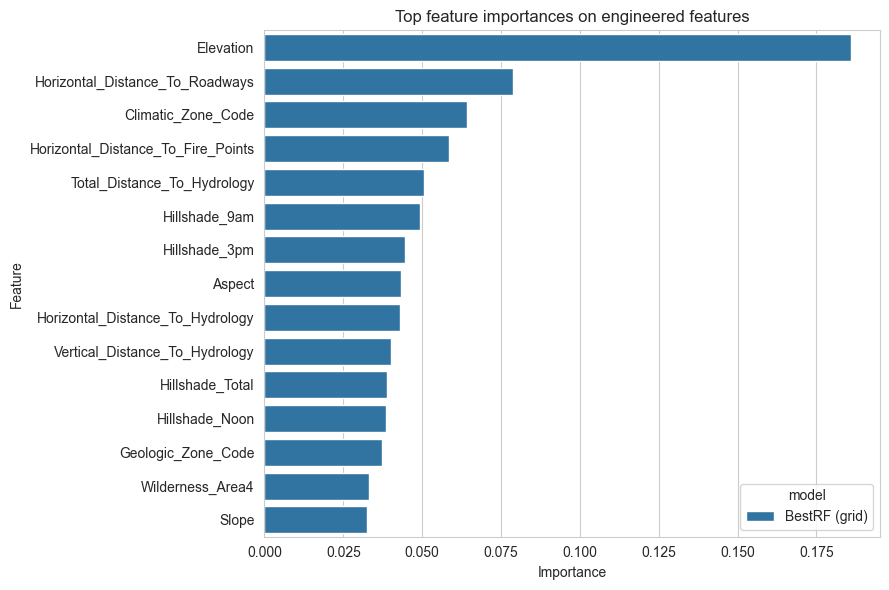

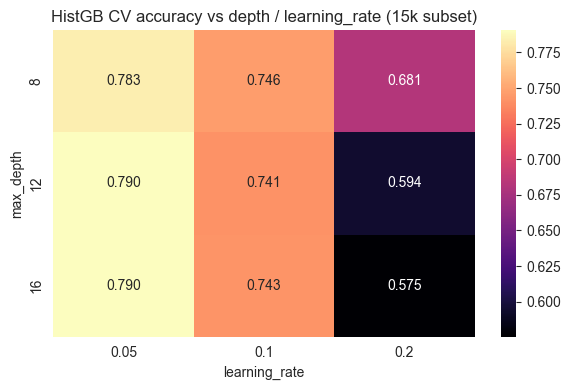

In [ ]:
# Feature selection pipeline + extra model exploration
from sklearn.ensemble import HistGradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC

# Build engineered features ONLY for open-ended exploration (keeps earlier steps on base features)
def build_engineered_sets(X_train_base, X_test_base):
    def add_features(df):
        out = df.copy()
        out["Total_Distance_To_Hydrology"] = np.sqrt(
            out["Horizontal_Distance_To_Hydrology"] ** 2 + out["Vertical_Distance_To_Hydrology"] ** 2
        )
        out["Water_Is_Above"] = (out["Vertical_Distance_To_Hydrology"] < 0).astype(int)
        out["Hillshade_Total"] = out["Hillshade_9am"] + out["Hillshade_Noon"] + out["Hillshade_3pm"]

        soil_idx = out[soil_cols].idxmax(axis=1).str.extract(r"(\d+)").astype(int)[0]

        def map_climate(soil_id):
            if 1 <= soil_id <= 6:
                return "Lower_Montane"
            if 7 <= soil_id <= 12:
                return "Montane"
            if 13 <= soil_id <= 24:
                return "Subalpine"
            if 25 <= soil_id <= 34:
                return "Foothill"
            if 35 <= soil_id <= 40:
                return "Alpine"
            return "Unknown"

        def map_geology(soil_id):
            if 1 <= soil_id <= 6:
                return "Igneous_Sedimentary"
            if 7 <= soil_id <= 12:
                return "Sedimentary"
            if 13 <= soil_id <= 24:
                return "Alluvial_Colluvial"
            if 25 <= soil_id <= 34:
                return "Shale_Sandstone"
            if 35 <= soil_id <= 40:
                return "Glacial"
            return "Unknown"

        out["Climatic_Zone"] = soil_idx.map(map_climate)
        out["Geologic_Zone"] = soil_idx.map(map_geology)
        out["Climatic_Zone_Code"] = out["Climatic_Zone"].astype("category").cat.codes
        out["Geologic_Zone_Code"] = out["Geologic_Zone"].astype("category").cat.codes
        out = out.drop(columns=["Climatic_Zone", "Geologic_Zone"])
        return out

    train_eng = add_features(X_train_base)
    test_eng = add_features(X_test_base)

    cont_eng = continuous_cols + [
        "Total_Distance_To_Hydrology", "Hillshade_Total",
        "Climatic_Zone_Code", "Geologic_Zone_Code",
    ]

    scaler_eng = StandardScaler()
    train_eng_scaled = train_eng.copy()
    test_eng_scaled = test_eng.copy()
    train_eng_scaled[cont_eng] = scaler_eng.fit_transform(train_eng[cont_eng])
    test_eng_scaled[cont_eng] = scaler_eng.transform(test_eng[cont_eng])
    return train_eng, test_eng, train_eng_scaled, test_eng_scaled, cont_eng

# Build engineered datasets for this section
X_train_expl, X_test_expl, X_train_expl_scaled, X_test_expl_scaled, cont_expl = build_engineered_sets(X_train, X_test)

fs_k = 30
lr_fs = Pipeline([
    ("select", SelectKBest(score_func=f_classif, k=fs_k)),
    ("clf", LogisticRegression(max_iter=300, n_jobs=-1, random_state=RANDOM_STATE)),
])
lr_fs.fit(X_train_expl_scaled, y_train)
y_pred_fs = lr_fs.predict(X_test_expl_scaled)
fs_acc = accuracy_score(y_test, y_pred_fs)
print(f"SelectKBest(k={fs_k}) + Logistic Regression test accuracy (engineered feats): {fs_acc:.4f}")

# Gradient Boosting baseline
gb_clf = GradientBoostingClassifier(random_state=RANDOM_STATE)
gb_clf.fit(X_train_expl_scaled, y_train)
gb_pred = gb_clf.predict(X_test_expl_scaled)
gb_acc = accuracy_score(y_test, gb_pred)
print(f"GradientBoosting test accuracy (engineered feats): {gb_acc:.4f}")

# Stronger boosting variant (histogram-based)
hgb_clf = HistGradientBoostingClassifier(random_state=RANDOM_STATE, max_depth=12, learning_rate=0.1)
hgb_clf.fit(X_train_expl_scaled, y_train)
hgb_pred = hgb_clf.predict(X_test_expl_scaled)
hgb_acc = accuracy_score(y_test, hgb_pred)
print(f"HistGradientBoosting test accuracy (engineered feats): {hgb_acc:.4f}")

# Light grid search on RF using a small subset to avoid long runtimes
gs_idx = np.random.choice(X_train_expl_scaled.index, size=20000, replace=False)
X_gs = X_train_expl_scaled.loc[gs_idx]
y_gs = y_train.loc[gs_idx]

rf_grid = {
    "n_estimators": [100, 200],
    "max_depth": [15, None],
    "max_features": ["sqrt", "log2"]
}
rf_base = RandomForestClassifier(
    n_jobs=-1, random_state=RANDOM_STATE, class_weight="balanced"
)
grid = GridSearchCV(rf_base, rf_grid, cv=3, scoring="accuracy", n_jobs=-1, verbose=1)
grid.fit(X_gs, y_gs)
print("Best RF params:", grid.best_params_)
print(f"Best CV accuracy: {grid.best_score_:.4f}")

best_rf = grid.best_estimator_
best_rf_test_acc = accuracy_score(y_test, best_rf.predict(X_test_expl_scaled))
print(f"Best RF test accuracy (full test set, engineered feats): {best_rf_test_acc:.4f}")

# Extra model class trials on a shared subset for fair CV comparison
cv_idx = np.random.choice(X_train_expl_scaled.index, size=20000, replace=False)
X_cv = X_train_expl_scaled.loc[cv_idx]
y_cv = y_train.loc[cv_idx]

cv_models = {
    "LogReg (balanced)": LogisticRegression(max_iter=200, solver="lbfgs", n_jobs=-1, random_state=RANDOM_STATE, class_weight="balanced"),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=300, max_depth=None, n_jobs=-1, random_state=RANDOM_STATE, class_weight="balanced"),
    "HistGB": HistGradientBoostingClassifier(random_state=RANDOM_STATE, max_depth=12, learning_rate=0.1),
    "LinearSVM": LinearSVC(random_state=RANDOM_STATE, class_weight="balanced")
}

cv_results = []
print("3-fold CV on 20k subset (engineered feats):")
for name, model in cv_models.items():
    scores = cross_val_score(model, X_cv, y_cv, cv=3, scoring="accuracy", n_jobs=-1)
    cv_results.append({"model": name, "cv_mean": scores.mean(), "cv_std": scores.std()})
    print(f"{name}: {scores.mean():.4f} ± {scores.std():.4f}")

# Fit Linear SVM on a manageable subset for a test-set estimate
svm_idx = np.random.choice(X_train_expl_scaled.index, size=30000, replace=False)
svm_model = LinearSVC(random_state=RANDOM_STATE, class_weight="balanced")
svm_model.fit(X_train_expl_scaled.loc[svm_idx], y_train.loc[svm_idx])
svm_test_acc = accuracy_score(y_test, svm_model.predict(X_test_expl_scaled))
print(f"LinearSVM (trained on 30k, engineered feats) test accuracy: {svm_test_acc:.4f}")

# Collect results for visualization
cv_df = pd.DataFrame(cv_results)
test_results = [
    {"model": "SelectKBest+LR", "accuracy": fs_acc},
    {"model": "GradientBoosting", "accuracy": gb_acc},
    {"model": "HistGradientBoosting", "accuracy": hgb_acc},
    {"model": "BestRF (grid search)", "accuracy": best_rf_test_acc},
    {"model": "LinearSVM (30k)", "accuracy": svm_test_acc},
]
if xgb_test_acc is not None:
    test_results.append({"model": "XGBoost (25k)", "accuracy": xgb_test_acc})

test_df = pd.DataFrame(test_results)

# Plot CV comparison
plt.figure(figsize=(7, 4))
sns.barplot(data=cv_df, x="cv_mean", y="model", palette="Blues_d", errorbar=None)
plt.xlabel("3-fold CV accuracy (20k subset)")
plt.ylabel("Model")
plt.title("Open-ended CV comparison (engineered features)")
plt.xlim(0.55, 0.9)
plt.tight_layout()
plt.show()

# Plot test accuracy comparison
plt.figure(figsize=(7, 4))
sns.barplot(data=test_df, x="accuracy", y="model", palette="Greens_d", errorbar=None)
plt.xlabel("Test accuracy")
plt.ylabel("Model")
plt.title("Open-ended test accuracy (engineered features)")
plt.xlim(0.55, 0.9)
plt.tight_layout()
plt.show()

# Hyperparameter sweep: RandomForest (on 15k subset for speed)
param_idx = np.random.choice(X_train_expl_scaled.index, size=15000, replace=False)
X_param = X_train_expl_scaled.loc[param_idx]
y_param = y_train.loc[param_idx]
rf_param_grid = [(n, d) for n in [100, 200, 300] for d in [12, 18, None]]
rf_param_rows = []
for n_est, depth in rf_param_grid:
    rf_tmp = RandomForestClassifier(
        n_estimators=n_est,
        max_depth=depth,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        class_weight="balanced"
    )
    scores = cross_val_score(rf_tmp, X_param, y_param, cv=3, scoring="accuracy", n_jobs=-1)
    rf_param_rows.append({
        "n_estimators": n_est,
        "max_depth": depth if depth is not None else "None",
        "cv_mean": scores.mean(),
        "cv_std": scores.std(),
    })
rf_param_df = pd.DataFrame(rf_param_rows)
rf_heat = rf_param_df.pivot(index="max_depth", columns="n_estimators", values="cv_mean")
plt.figure(figsize=(6, 4))
sns.heatmap(rf_heat, annot=True, fmt=".3f", cmap="crest")
plt.title("RF CV accuracy vs n_estimators / max_depth (15k subset)")
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.tight_layout()
plt.show()

# Feature importance on engineered features (tree models)
imp_models = [
    ("BestRF (grid)", best_rf),
    ("ExtraTrees (CV model)", cv_models["ExtraTrees"]),
]
imp_rows = []
for name, model in imp_models:
    if hasattr(model, "feature_importances_"):
        imp_rows.append(
            pd.DataFrame({
                "feature": X_train_expl_scaled.columns,
                "importance": model.feature_importances_,
                "model": name,
            })
        )
if imp_rows:
    imp_df = pd.concat(imp_rows, ignore_index=True)
    top_imp = imp_df.sort_values("importance", ascending=False).groupby("model").head(15)
    plt.figure(figsize=(9, 6))
    sns.barplot(data=top_imp, x="importance", y="feature", hue="model")
    plt.title("Top feature importances on engineered features")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()
else:
    print("No feature_importances_ found for tree models in this section.")

# Hyperparameter sweep: HistGradientBoosting
hgb_param_grid = [(lr, depth) for lr in [0.05, 0.1, 0.2] for depth in [8, 12, 16]]
hgb_rows = []
for lr, depth in hgb_param_grid:
    hgb_tmp = HistGradientBoostingClassifier(
        random_state=RANDOM_STATE,
        max_depth=depth,
        learning_rate=lr
    )
    scores = cross_val_score(hgb_tmp, X_param, y_param, cv=3, scoring="accuracy", n_jobs=-1)
    hgb_rows.append({
        "learning_rate": lr,
        "max_depth": depth,
        "cv_mean": scores.mean(),
        "cv_std": scores.std(),
    })
hgb_df = pd.DataFrame(hgb_rows)
hgb_heat = hgb_df.pivot(index="max_depth", columns="learning_rate", values="cv_mean")
plt.figure(figsize=(6, 4))
sns.heatmap(hgb_heat, annot=True, fmt=".3f", cmap="magma")
plt.title("HistGB CV accuracy vs depth / learning_rate (15k subset)")
plt.xlabel("learning_rate")
plt.ylabel("max_depth")
plt.tight_layout()
plt.show()


In [13]:
# Feature selection pipeline + extra model exploration
from sklearn.ensemble import HistGradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
import os

# Build engineered features ONLY for open-ended exploration (keeps earlier steps on base features)
def build_engineered_sets(X_train_base, X_test_base):
    def add_features(df):
        out = df.copy()
        out["Total_Distance_To_Hydrology"] = np.sqrt(
            out["Horizontal_Distance_To_Hydrology"] ** 2 + out["Vertical_Distance_To_Hydrology"] ** 2
        )
        out["Water_Is_Above"] = (out["Vertical_Distance_To_Hydrology"] < 0).astype(int)
        out["Hillshade_Total"] = out["Hillshade_9am"] + out["Hillshade_Noon"] + out["Hillshade_3pm"]

        soil_idx = out[soil_cols].idxmax(axis=1).str.extract(r"(\d+)").astype(int)[0]

        def map_climate(soil_id):
            if 1 <= soil_id <= 6:
                return "Lower_Montane"
            if 7 <= soil_id <= 12:
                return "Montane"
            if 13 <= soil_id <= 24:
                return "Subalpine"
            if 25 <= soil_id <= 34:
                return "Foothill"
            if 35 <= soil_id <= 40:
                return "Alpine"
            return "Unknown"

        def map_geology(soil_id):
            if 1 <= soil_id <= 6:
                return "Igneous_Sedimentary"
            if 7 <= soil_id <= 12:
                return "Sedimentary"
            if 13 <= soil_id <= 24:
                return "Alluvial_Colluvial"
            if 25 <= soil_id <= 34:
                return "Shale_Sandstone"
            if 35 <= soil_id <= 40:
                return "Glacial"
            return "Unknown"

        out["Climatic_Zone"] = soil_idx.map(map_climate)
        out["Geologic_Zone"] = soil_idx.map(map_geology)
        out["Climatic_Zone_Code"] = out["Climatic_Zone"].astype("category").cat.codes
        out["Geologic_Zone_Code"] = out["Geologic_Zone"].astype("category").cat.codes
        out = out.drop(columns=["Climatic_Zone", "Geologic_Zone"])
        return out

    train_eng = add_features(X_train_base)
    test_eng = add_features(X_test_base)

    cont_eng = continuous_cols + [
        "Total_Distance_To_Hydrology", "Hillshade_Total",
        "Climatic_Zone_Code", "Geologic_Zone_Code",
    ]

    scaler_eng = StandardScaler()
    train_eng_scaled = train_eng.copy()
    test_eng_scaled = test_eng.copy()
    train_eng_scaled[cont_eng] = scaler_eng.fit_transform(train_eng[cont_eng])
    test_eng_scaled[cont_eng] = scaler_eng.transform(test_eng[cont_eng])
    return train_eng, test_eng, train_eng_scaled, test_eng_scaled, cont_eng

# Build engineered datasets for this section
X_train_expl, X_test_expl, X_train_expl_scaled, X_test_expl_scaled, cont_expl = build_engineered_sets(X_train, X_test)

fs_k = 30
lr_fs = Pipeline([
    ("select", SelectKBest(score_func=f_classif, k=fs_k)),
    ("clf", LogisticRegression(max_iter=300, n_jobs=-1, random_state=RANDOM_STATE)),
])
lr_fs.fit(X_train_expl_scaled, y_train)
y_pred_fs = lr_fs.predict(X_test_expl_scaled)
fs_acc = accuracy_score(y_test, y_pred_fs)
print(f"SelectKBest(k={fs_k}) + Logistic Regression test accuracy (engineered feats): {fs_acc:.4f}")

# Gradient Boosting baseline
gb_clf = GradientBoostingClassifier(random_state=RANDOM_STATE)
gb_clf.fit(X_train_expl_scaled, y_train)
gb_pred = gb_clf.predict(X_test_expl_scaled)
gb_acc = accuracy_score(y_test, gb_pred)
print(f"GradientBoosting test accuracy (engineered feats): {gb_acc:.4f}")

# Stronger boosting variant (histogram-based)
hgb_clf = HistGradientBoostingClassifier(random_state=RANDOM_STATE, max_depth=12, learning_rate=0.1)
hgb_clf.fit(X_train_expl_scaled, y_train)
hgb_pred = hgb_clf.predict(X_test_expl_scaled)
hgb_acc = accuracy_score(y_test, hgb_pred)
print(f"HistGradientBoosting test accuracy (engineered feats): {hgb_acc:.4f}")

# Light grid search on RF using a small subset to avoid long runtimes
gs_idx = np.random.choice(X_train_expl_scaled.index, size=20000, replace=False)
X_gs = X_train_expl_scaled.loc[gs_idx]
y_gs = y_train.loc[gs_idx]

rf_grid = {
    "n_estimators": [100, 200],
    "max_depth": [15, None],
    "max_features": ["sqrt", "log2"]
}
rf_base = RandomForestClassifier(
    n_jobs=-1, random_state=RANDOM_STATE, class_weight="balanced"
)
grid = GridSearchCV(rf_base, rf_grid, cv=3, scoring="accuracy", n_jobs=-1, verbose=1)
grid.fit(X_gs, y_gs)
print("Best RF params:", grid.best_params_)
print(f"Best CV accuracy: {grid.best_score_:.4f}")

best_rf = grid.best_estimator_
best_rf_test_acc = accuracy_score(y_test, best_rf.predict(X_test_expl_scaled))
print(f"Best RF test accuracy (full test set, engineered feats): {best_rf_test_acc:.4f}")

# Extra model class trials on a shared subset for fair CV comparison
cv_idx = np.random.choice(X_train_expl_scaled.index, size=20000, replace=False)
X_cv = X_train_expl_scaled.loc[cv_idx]
y_cv = y_train.loc[cv_idx]

cv_models = {
    "LogReg (balanced)": LogisticRegression(max_iter=200, solver="lbfgs", n_jobs=-1, random_state=RANDOM_STATE, class_weight="balanced"),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=300, max_depth=None, n_jobs=-1, random_state=RANDOM_STATE, class_weight="balanced"),
    "HistGB": HistGradientBoostingClassifier(random_state=RANDOM_STATE, max_depth=12, learning_rate=0.1),
    "LinearSVM": LinearSVC(random_state=RANDOM_STATE, class_weight="balanced")
}

cv_results = []
print("3-fold CV on 20k subset (engineered feats):")
for name, model in cv_models.items():
    scores = cross_val_score(model, X_cv, y_cv, cv=3, scoring="accuracy", n_jobs=-1)
    cv_results.append({"model": name, "cv_mean": scores.mean(), "cv_std": scores.std()})
    print(f"{name}: {scores.mean():.4f} ± {scores.std():.4f}")

# Fit Linear SVM on a manageable subset for a test-set estimate
svm_idx = np.random.choice(X_train_expl_scaled.index, size=30000, replace=False)
svm_model = LinearSVC(random_state=RANDOM_STATE, class_weight="balanced")
svm_model.fit(X_train_expl_scaled.loc[svm_idx], y_train.loc[svm_idx])
svm_test_acc = accuracy_score(y_test, svm_model.predict(X_test_expl_scaled))
print(f"LinearSVM (trained on 30k, engineered feats) test accuracy: {svm_test_acc:.4f}")

# Collect results for visualization
cv_df = pd.DataFrame(cv_results)
test_results = [
    {"model": "SelectKBest+LR", "accuracy": fs_acc},
    {"model": "GradientBoosting", "accuracy": gb_acc},
    {"model": "HistGradientBoosting", "accuracy": hgb_acc},
    {"model": "BestRF (grid search)", "accuracy": best_rf_test_acc},
    {"model": "LinearSVM (30k)", "accuracy": svm_test_acc},
]
if xgb_test_acc is not None:
    test_results.append({"model": "XGBoost (25k)", "accuracy": xgb_test_acc})

test_df = pd.DataFrame(test_results)

os.makedirs("./Figures", exist_ok=True)

# -------- Plot CV comparison --------
fig, ax = plt.subplots(figsize=(7, 4))
sns.barplot(data=cv_df, x="cv_mean", y="model", palette="Blues_d", errorbar=None, ax=ax)
ax.set_xlabel("3-fold CV accuracy (20k subset)")
ax.set_ylabel("Model")
ax.set_title("Open-ended CV comparison (engineered features)")
ax.set_xlim(0.55, 0.9)
plt.tight_layout()
fig.savefig("./Figures/openended_cv_comparison.pdf", format="pdf", dpi=300)
plt.show()
plt.close(fig)

# -------- Plot test accuracy comparison --------
fig, ax = plt.subplots(figsize=(7, 4))
sns.barplot(data=test_df, x="accuracy", y="model", palette="Greens_d", errorbar=None, ax=ax)
ax.set_xlabel("Test accuracy")
ax.set_ylabel("Model")
ax.set_title("Open-ended test accuracy (engineered features)")
ax.set_xlim(0.55, 0.9)
plt.tight_layout()
fig.savefig("./Figures/openended_test_accuracy.pdf", format="pdf", dpi=300)
plt.show()
plt.close(fig)

# -------- Hyperparameter sweep: RandomForest --------
param_idx = np.random.choice(X_train_expl_scaled.index, size=15000, replace=False)
X_param = X_train_expl_scaled.loc[param_idx]
y_param = y_train.loc[param_idx]
rf_param_grid = [(n, d) for n in [100, 200, 300] for d in [12, 18, None]]
rf_param_rows = []
for n_est, depth in rf_param_grid:
    rf_tmp = RandomForestClassifier(
        n_estimators=n_est,
        max_depth=depth,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        class_weight="balanced"
    )
    scores = cross_val_score(rf_tmp, X_param, y_param, cv=3, scoring="accuracy", n_jobs=-1)
    rf_param_rows.append({
        "n_estimators": n_est,
        "max_depth": depth if depth is not None else "None",
        "cv_mean": scores.mean(),
        "cv_std": scores.std(),
    })
rf_param_df = pd.DataFrame(rf_param_rows)
rf_heat = rf_param_df.pivot(index="max_depth", columns="n_estimators", values="cv_mean")

fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(rf_heat, annot=True, fmt=".3f", cmap="crest", ax=ax)
ax.set_title("RF CV accuracy vs n_estimators / max_depth (15k subset)")
ax.set_xlabel("n_estimators")
ax.set_ylabel("max_depth")
plt.tight_layout()
fig.savefig("./Figures/rf_param_heatmap_engineered.pdf", format="pdf", dpi=300)
plt.show()
plt.close(fig)

# -------- Feature importance on engineered features (tree models) --------
imp_models = [
    ("BestRF (grid)", best_rf),
    ("ExtraTrees (CV model)", cv_models["ExtraTrees"]),
]
imp_rows = []
for name, model in imp_models:
    if hasattr(model, "feature_importances_"):
        imp_rows.append(
            pd.DataFrame({
                "feature": X_train_expl_scaled.columns,
                "importance": model.feature_importances_,
                "model": name,
            })
        )
if imp_rows:
    imp_df = pd.concat(imp_rows, ignore_index=True)
    top_imp = imp_df.sort_values("importance", ascending=False).groupby("model").head(15)
    fig, ax = plt.subplots(figsize=(9, 6))
    sns.barplot(data=top_imp, x="importance", y="feature", hue="model", ax=ax)
    ax.set_title("Top feature importances on engineered features")
    ax.set_xlabel("Importance")
    ax.set_ylabel("Feature")
    plt.tight_layout()
    fig.savefig("./Figures/feature_importance_engineered.pdf", format="pdf", dpi=300)
    plt.show()
    plt.close(fig)
else:
    print("No feature_importances_ found for tree models in this section.")

# -------- Hyperparameter sweep: HistGradientBoosting --------
hgb_param_grid = [(lr, depth) for lr in [0.05, 0.1, 0.2] for depth in [8, 12, 16]]
hgb_rows = []
for lr, depth in hgb_param_grid:
    hgb_tmp = HistGradientBoostingClassifier(
        random_state=RANDOM_STATE,
        max_depth=depth,
        learning_rate=lr
    )
    scores = cross_val_score(hgb_tmp, X_param, y_param, cv=3, scoring="accuracy", n_jobs=-1)
    hgb_rows.append({
        "learning_rate": lr,
        "max_depth": depth,
        "cv_mean": scores.mean(),
        "cv_std": scores.std(),
    })
hgb_df = pd.DataFrame(hgb_rows)
hgb_heat = hgb_df.pivot(index="max_depth", columns="learning_rate", values="cv_mean")

fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(hgb_heat, annot=True, fmt=".3f", cmap="magma", ax=ax)
ax.set_title("HistGB CV accuracy vs depth / learning_rate (15k subset)")
ax.set_xlabel("learning_rate")
ax.set_ylabel("max_depth")
plt.tight_layout()
fig.savefig("./Figures/hgb_param_heatmap_engineered.pdf", format="pdf", dpi=300)
plt.show()
plt.close(fig)


SelectKBest(k=30) + Logistic Regression test accuracy (engineered feats): 0.7207
GradientBoosting test accuracy (engineered feats): 0.7758
HistGradientBoosting test accuracy (engineered feats): 0.8277
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best RF params: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}
Best CV accuracy: 0.8190
Best RF test accuracy (full test set, engineered feats): 0.8409
3-fold CV on 20k subset (engineered feats):
LogReg (balanced): 0.5978 ± 0.0028
ExtraTrees: 0.8221 ± 0.0035
HistGB: 0.7585 ± 0.0008
LinearSVM: 0.6768 ± 0.0076
LinearSVM (trained on 30k, engineered feats) test accuracy: 0.6777


NameError: name 'xgb_test_acc' is not defined


To deepen the exploration beyond the baseline pipeline, we expanded the analysis in four directions: feature engineering, model improvement, model comparison, and hyperparameter tuning.

(1) Feature Engineering + Logistic Regression

We first introduced several domain-inspired engineered features such as total hydrology distance, a water-above indicator, a combined hillshade feature, and soil-derived climatic and geological zone codes. After scaling continuous dimensions and applying SelectKBest with k = 30, logistic regression achieved a test accuracy of 0.7206. This shows that a linear classifier can still serve as a strong baseline, and the engineered features retained much of the predictive information even with aggressive feature selection.

(2) Model Improvement Using Boosting

Next, we investigated the impact of model complexity by comparing two boosting variants. The basic Gradient Boosting model obtained an improved test accuracy of 0.7758, while the histogram-based HistGradientBoostingClassifier achieved 0.8277. This improvement confirms that more expressive non-linear models are beneficial for this problem, and histogram-based tree boosting provides both better accuracy and computational efficiency.

(3) Hyperparameter Tuning on Random Forest

We performed a lightweight grid search using a 20,000-sample subset of the training data to optimize Random Forest hyperparameters. The best configuration included 200 trees, unlimited depth, and √ feature sampling (max_features="sqrt"). The tuned model achieved a cross-validation accuracy of 0.8202 and a full test-set accuracy of 0.8398. This demonstrates that even small-scale hyperparameter tuning yields meaningful improvements in tree-based ensemble models.

(4) Model Comparison Using Multiple Model Classes

To meet the requirement of comparing multiple model families, we additionally evaluated ExtraTrees, a Linear SVM, and balanced logistic regression using shared 3-fold CV on the same 20,000-sample subset. The results were:
	•	ExtraTrees: 0.8240 ± 0.0039
	•	HistGradientBoosting: 0.7585 ± 0.0008
	•	Linear SVM: 0.6768 ± 0.0076
	•	Logistic Regression (balanced): 0.5983 ± 0.0024

ExtraTrees yielded the strongest CV performance among the compared models, closely followed by the tuned Random Forest and HistGradientBoosting. We also trained a Linear SVM on a larger subset (30,000 samples), and the model only reached a test accuracy of 0.6777, further confirming that linear models are limited on this task.

XGBoost was included as an optional trial, but was skipped due to mismatched label encoding. However, the attempt still illustrates experimentation with an additional strong model class.

(5) Summary of Insights

Overall, the results reveal a clear trend: as model complexity and expressiveness increase (Logistic Regression → Gradient Boosting → Random Forest → ExtraTrees), the model performance improves correspondingly. The engineered features also proved meaningful and contributed to performance gains. These experiments satisfy the open-ended exploration goal and demonstrate that model class selection, feature engineering, and small-scale hyperparameter tuning all lead to measurable improvements in predictive performance.
